In [31]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)
    
def makeROCPlot(pred,true,label="",noSkill=True):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL")
    plt.legend()
    return auc


In [2]:
datadir = "../data/neatms/dataset2/dataset2/"
resolution = 60
window = 1.0
rawDataDir = datadir + "tmp/"


In [3]:
#Dataset2
ms1ppm = 11.75
peakWidth = (3,81)
s2n = 10
noise = 100
prefilter = 3
mzDiff = -0.016

In [4]:
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
peakList = pd.DataFrame(det.peakList)
peakList

mz        rt  rt_start    rt_end  sample1_dilution_1_4.mzML  \
FT0001   55.053451  4.878935  4.857085  5.002174               5.190202e+05   
FT0002   55.018166  0.634405  0.602107  0.704548               6.552425e+05   
FT0003   55.053480  4.791289  4.716576  4.804399               6.405498e+05   
FT0004   55.042011  4.420581  4.332440  4.474144               2.491939e+07   
FT0005   55.041975  5.497349  5.414131  5.501727               5.991240e+06   
...            ...       ...       ...       ...                        ...   
FT6840  788.615888  4.707754  4.686141  4.733746               4.044556e+05   
FT6841  789.615149  4.716341  4.707587  4.716341               0.000000e+00   
FT6842  791.158887  4.721062  4.716127  4.727088               7.085825e+05   
FT6843  792.162258  4.721078  4.716332  4.727088               6.557580e+05   
FT6844  793.165196  4.720863  4.715968  4.727088               6.020861e+04   

        sample10_dilution_1_2.mzML  sample11_dilution_100.mzML  \
FT0001                1.054540e+06                8.830546e+05   
FT0002                7.026692e+05                6.163222e+05   
FT0003                7.153411e+05                5.581761e+05   
FT0004                1.360541e+07                8.475779e+06   
FT0005                4.755463e+06                3.556679e+06   
...                            ...                         ...   
FT6840                4.107730e+04                1.619961e+06   
FT6841                5.231473e+04                0.000000e+00   
FT6842                5.833578e+05                2.116127e+06   
FT6843                8.382153e+05                9.337738e+05   
FT6844                1.622830e+05                5.422916e+04   

        sample12_dilution_7_5.mzML  sample13_dilution_1_8.mzML  \
FT0001                6.546003e+05                9.359172e+05   
FT0002                5.407131e+05                2.733202e+05   
FT0003                6.526306e+05                7.284340e+05   
FT0004                1.412671e+07                9.539135e+04   
FT0005                4.420717e+06                3.420416e+06   
...                            ...                         ...   
FT6840                1.452596e+05                0.000000e+00   
FT6841                1.151856e+04                0.000000e+00   
FT6842                1.922280e+06                1.991804e+06   
FT6843                7.131300e+05                7.426883e+05   
FT6844                7.465577e+04                4.530660e+04   

        sample14_dilution_3.mzML  ...  sample36_dilution_1_4.mzML  \
FT0001              4.461932e+05  ...                6.312641e+05   
FT0002              7.583222e+05  ...                7.385000e+05   
FT0003              1.058205e+06  ...                5.185101e+05   
FT0004              2.464958e+07  ...                2.542607e+07   
FT0005              8.475144e+05  ...                3.940388e+06   
...                          ...  ...                         ...   
FT6840              0.000000e+00  ...                4.967156e+04   
FT6841              0.000000e+00  ...                0.000000e+00   
FT6842              1.809964e+06  ...                6.074128e+05   
FT6843              2.662187e+05  ...                2.113666e+05   
FT6844              5.284328e+04  ...                5.432874e+04   

        sample37_dilution_1_8.mzML  sample38_dilution_3.mzML  \
FT0001                6.189578e+05              5.169379e+05   
FT0002                7.170968e+05              1.839402e+05   
FT0003                6.885745e+05              6.523820e+05   
FT0004                2.555244e+07              6.361552e+06   
FT0005                4.966296e+06              3.541935e+06   
...                            ...                       ...   
FT6840                2.457464e+04              2.999188e+05   
FT6841                0.000000e+00              0.000000e+00   
FT6842                1.976276e+06              2.036927e+06   
FT6843      

In [5]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['sample10_dilution_1_2.mzML', 'sample11_dilution_100.mzML', 'sample12_dilution_7_5.mzML', 'sample13_dilution_1_8.mzML', 'sample14_dilution_3.mzML', 'sample15_dilution_15.mzML', 'sample16_dilution_50.mzML', 'sample17_dilution_20.mzML', 'sample18_dilution_50.mzML', 'sample19_dilution_5.mzML', 'sample1_dilution_1_4.mzML', 'sample20_dilution_1_6.mzML', 'sample21_dilution_100.mzML', 'sample22_dilution_7_5.mzML', 'sample23_dilution_2.mzML', 'sample24_dilution_50.mzML', 'sample25_dilution_10.mzML', 'sample26_dilution_1_2.mzML', 'sample27_dilution_2.mzML', 'sample28_dilution_15.mzML', 'sample29_dilution_10.mzML', 'sample2_dilution_5.mzML', 'sample30_dilution_100.mzML', 'sample31_dilution_1_6.mzML', 'sample32_dilution_1_8.mzML', 'sample33_dilution_1_2.mzML', 'sample34_dilution_20.mzML', 'sample35_dilution_7_5.mzML', 'sample36_dilution_1_4.mzML', 'sample37_dilution_1_8.mzML', 'sample38_dilution_3.mzML', 'sample39_dilution_2.mzML', 'sample3_dilution_20.mzML', 'sample40_dilution_3.mzML', 'sample4

In [6]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

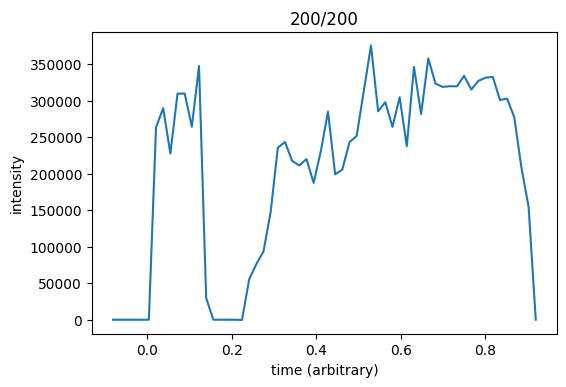

Enter classification (1=True Peak, 0=Artifact): 


 0


In [7]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,200)
    tmp = peakList.loc[inds,:]
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)
    peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [7]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [8]:
neatMSPeakList = pd.read_csv(datadir + "xcms_peak_list.csv",sep="\t",index_col=0)
neatMSPeakList["feature_id"] = neatMSPeakList.index.values
neatMSPeakList["feature_id2"] = neatMSPeakList.index.values
neatMSPeakList = neatMSPeakList.melt(id_vars = ["mzmed","rtmed","rtmin","rtmax","feature_id"],
                    value_vars = [x for x in neatMSPeakList.columns.values if ".mzML" in x],
                   var_name="sample", value_name="into")
neatMSPeakList["mzmin"] = neatMSPeakList["mzmed"].values - (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["mzmax"] = neatMSPeakList["mzmed"].values + (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["intb"] = neatMSPeakList["into"].values
neatMSPeakList["maxo"] = neatMSPeakList["into"].values
neatMSPeakList["sn"] = [10 for _ in range(len(neatMSPeakList))]
neatMSPeakList["sample_name"] = neatMSPeakList["sample"].values
neatMSPeakList["rtmin"] = neatMSPeakList["rtmin"].values - .2 * 60
neatMSPeakList["rtmax"] = neatMSPeakList["rtmin"].values + .2 * 60
neatMSPeakList = neatMSPeakList.rename({"mzmed":"mz","rtmed":"rt"},axis=1)

neatMSPeakList.to_csv(datadir + "neatms_peak_list.csv",index=False)
neatMSPeakList


mz          rt       rtmin       rtmax feature_id  \
0        55.053451  292.736084  279.425110  291.425110     FT0001   
1        55.018166   38.064308   24.126396   36.126396     FT0002   
2        55.053480  287.477356  270.994537  282.994537     FT0003   
3        55.042011  265.234863  247.946381  259.946381     FT0004   
4        55.041975  329.840912  312.847839  324.847839     FT0005   
...            ...         ...         ...         ...        ...   
266911  788.615888  282.465225  269.168457  281.168457     FT6840   
266912  789.615149  282.980438  270.455231  282.455231     FT6841   
266913  791.158887  283.263733  270.967590  282.967590     FT6842   
266914  792.162258  283.264679  270.979919  282.979919     FT6843   
266915  793.165196  283.251770  270.958099  282.958099     FT6844   

                           sample          into       mzmin       mzmax  \
0       sample1_dilution_1_4.mzML  5.190202e+05   55.052804   55.054098   
1       sample1_dilution_1_4.mzML  6.552425e+05   55.017520   55.018813   
2       sample1_dilution_1_4.mzML  6.405498e+05   55.052833   55.054127   
3       sample1_dilution_1_4.mzML  2.491939e+07   55.041365   55.042658   
4       sample1_dilution_1_4.mzML  5.991240e+06   55.041328   55.042621   
...                           ...           ...         ...         ...   
266911   sample9_dilution_10.mzML  2.141416e+05  788.606622  788.625155   
266912   sample9_dilution_10.mzML  1.241940e+04  789.605871  789.624427   
266913   sample9_dilution_10.mzML  4.803302e+05  791.149591  791.168183   
266914   sample9_dilution_10.mzML  6.222407e+05  792.152950  792.171566   
266915   sample9_dilution_10.mzML  4.913823e+04  793.155876  793.174516   

                intb          maxo  sn                sample_name  
0       5.190202e+05  5.190202e+05  10  sample1_dilution_1_4.mzML  
1       6.552425e+05  6.552425e+05  10  sample1_dilution_1_4.mzML  
2       6.405498e+05  6.405498e+05  10  sample1_dilution_1_4.mzML  
3       2.491939e+07  2.491939e+07  10  sample1_dilution_1_4.mzML  
4       5.991240e+06  5.991240e+06  10  sample1_dilution_1_4.mzML  
...              ...           ...  ..                        ...  
266911  2.141416e+05  2.141416e+05  10   sample9_dilution_10.mzML  
266912  1.241940e+04  1.241940e+04  10   sample9_dilution_10.mzML  
266913  4.803302e+05  4.803302e+05  10   sample9_dilution_10.mzML  
266914  6.222407e+05  6.222407e+05  10   sample9_dilution_10.mzML  
266915  4.913823e+04  4.913823e+04  10   sample9_dilution_10.mzML  

[266916 rows x 13 columns]

In [9]:
feature_table_path = datadir+"neatms_peak_list.csv"
input_data = 'xcms'
experiment = ntms.Experiment(rawDataDir, feature_table_path, input_data)

In [10]:
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)

In [11]:
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)
nn_handler.get_model_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 120, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 120, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 60, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 60, 64)         18496     
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               983168    
                                                           

In [12]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\data.py:218: RuntimeWarning: invalid value encountered in true_divide
  yinterp = np.divide(yinterp, yinterp.max())


203/203 [==============================] - 11s 56ms/step


In [13]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

feature ID                 sample         m/z  retention time  \
0                0  sample10_dilution_1_2   55.053451        4.878935   
1                0  sample11_dilution_100   55.053451        4.878935   
2                0  sample12_dilution_7_5   55.053451        4.878935   
3                0  sample13_dilution_1_8   55.053451        4.878935   
4                0    sample14_dilution_3   55.053451        4.878935   
...            ...                    ...         ...             ...   
250812        6843   sample4_dilution_1_4  793.165196        4.720863   
250813        6843    sample5_dilution_15  793.165196        4.720863   
250814        6843   sample7_dilution_1_6  793.165196        4.720863   
250815        6843     sample8_dilution_5  793.165196        4.720863   
250816        6843    sample9_dilution_10  793.165196        4.720863   

              height          area         label  
0       1.054540e+06  1.054540e+06   Low_quality  
1       8.830546e+05  8.830546e+05   Low_quality  
2       6.546003e+05  6.546003e+05  High_quality  
3       9.359172e+05  9.359172e+05  High_quality  
4       4.461932e+05  4.461932e+05  High_quality  
...              ...           ...           ...  
250812  6.197212e+04  6.197212e+04  High_quality  
250813  2.815906e+04  2.815906e+04  High_quality  
250814  1.803782e+05  1.803782e+05  High_quality  
250815  5.424553e+04  5.424553e+04  High_quality  
250816  4.913823e+04  4.913823e+04  High_quality  

[250817 rows x 7 columns]

In [15]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data,peakList["mz"],rts,align=True)

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 


In [16]:
if __name__ == "__main__":
    rts = peakList_labeled["rt"].values
    X_labeled = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],peakList_labeled["rt"],align=False)
    y_labeled = peakList_labeled["classification"].values
    y_labeled = np.array([[-1*y + 1,y] for y in y_labeled])

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [17]:
X_signal = integ.generateSignalPeaks(peakList,raw_data,n=50)
X_noise = integ.generateFalsePeaks(peakList,raw_data,n=50)
X_syn = np.concatenate((X_signal,X_noise),axis=0)
y_syn = np.array([[0.0,1.0] for _ in X_signal] + [[1.0,0.0] for _ in X_noise])

forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


In [18]:
pkl.dump([X,X_labeled,y_labeled,X_syn,y_syn],open(datadir +"model_selection_data.pkl","wb"))

In [19]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open(datadir +"model_selection_data.pkl","rb"))

In [42]:
# if __name__ == "__main__":
#     X_unaligned = integ.makeDataMatrix(raw_data,peakList_labeled["mz"],peakList_labeled["rt"],align=False)
#     X_aligned = integ.makeDataMatrix(raw_data,peakList_labeled["mz"],peakList_labeled["rt"],align=True)

In [43]:
# plt.scatter(X_unaligned.flatten(),X_aligned.flatten(),s=3,c="black")

In [44]:
# i = rd.choice(list(range(len(peakList_labeled))))
# for x in range(len(raw_data)):
#     plt.plot(X_unaligned[x*len(peakList_labeled) + i])
# plt.figure()
# for x in range(len(raw_data)):
#     plt.plot(X_aligned[x*len(peakList_labeled) + i])


In [21]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,10,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/10
1407/1407 [==============================] - 196s 138ms/step - loss: 0.1875 - mean_absolute_error: 0.1091 - val_loss: 0.1020 - val_mean_absolute_error: 0.0311
Epoch 2/10
1407/1407 [==============================] - 151s 107ms/step - loss: 0.0931 - mean_absolute_error: 0.0255 - val_loss: 0.0894 - val_mean_absolute_error: 0.0197
Epoch 3/10
1407/1407 [==============================] - 150s 107ms/step - loss: 0.0832 - mean_absolute_error: 0.0179 - val_loss: 0.0847 - val_mean_absolute_error: 0.0158
Epoch 4/10
1407/1407 [==============================] - 144s 102ms/step - loss: 0.0786 - mean_absolute_error: 0.0156 - val_loss: 0.0816 - val_mean_absolute_error: 0.0145
Epoch 5/10
1407/1407 [==============================] - 143s 101ms/step - loss: 0.0755 - mean_absolute_error: 0.0152 - val_loss: 0.0795 - val_mean_absolute_error: 0.0144
Epoch 6/10
1407/1407 [========

In [22]:
integ.save(datadir + "smoothed_only/")

In [43]:
integ.load(datadir + "smoothed_only/")

In [20]:
peaks_test = peakList_labeled.reset_index()
peaks_test

index          mz        rt  rt_start    rt_end  \
0    FT3485  293.283905  4.812851  4.804158  4.817831   
1    FT5560  457.147417  3.886845  3.882333  3.891221   
2    FT3376  287.010001  4.188930  4.153987  4.210883   
3    FT4630  372.259524  2.928649  2.923814  2.939878   
4    FT2628  241.656420  2.183268  2.178868  2.186672   
..      ...         ...       ...       ...       ...   
195  FT6720  730.594012  4.672661  4.672661  4.738226   
196  FT4263  345.231375  1.936240  1.915229  1.988501   
197  FT0093   69.069981  4.567793  4.561928  4.574180   
198  FT4223  342.308613  5.041351  5.031819  5.045849   
199  FT2480  231.933321  0.419073  0.311481  0.486962   

     sample1_dilution_1_4.mzML  sample10_dilution_1_2.mzML  \
0                 1.196851e+05                1.266681e+05   
1                 3.296867e+04                1.129944e+05   
2                 1.837143e+05                1.575508e+05   
3                 2.766808e+04                1.959507e+04   
4                 7.852419e+03                0.000000e+00   
..                         ...                         ...   
195               0.000000e+00                3.704068e+04   
196               8.295197e+05                8.449336e+05   
197               6.379235e+05                5.950299e+05   
198               1.143333e+06                2.232761e+05   
199               2.533605e+06                2.982088e+06   

     sample11_dilution_100.mzML  sample12_dilution_7_5.mzML  \
0                  7.244186e+05                6.060086e+05   
1                  1.276349e+05                2.415102e+04   
2                  3.904883e+05                2.488770e+05   
3                  3.986609e+04                3.629632e+04   
4                  1.912427e+04                0.000000e+00   
..                          ...                         ...   
195                0.000000e+00                0.000000e+00   
196                8.402581e+05                7.275928e+05   
197                6.754514e+05                5.465666e+05   
198                1.205784e+06                9.616911e+05   
199                4.406599e+06                4.157384e+06   

     sample13_dilution_1_8.mzML  ...  sample37_dilution_1_8.mzML  \
0                  6.316327e+05  ...                6.241851e+05   
1                  5.145697e+04  ...                4.530723e+04   
2                  4.463421e+05  ...                2.688440e+05   
3                  4.597820e+04  ...                4.310348e+04   
4                  1.314351e+04  ...                0.000000e+00   
..                          ...  ...                         ...   
195                2.448994e+04  ...                0.000000e+00   
196                9.997347e+05  ...                8.701180e+05   
197                7.532619e+05  ...                6.769637e+05   
198                9.569666e+05  ...                6.600290e+05   
199                1.668774e+06  ...                3.192688e+06   

     sample38_dilution_3.mzML  sample39_dilution_2.mzML  \
0                7.794486e+05              5.302952e+05   
1                0.000000e+00              3.466157e+04   
2                7.911880e+04              3.397521e+05   
3                4.270847e+04              1.839141e+04   
4                0.000000e+00              0.000000e+00   
..                        ...                       ...   
195              0.000000e+00              1.326894e+04   
196              9.406287e+05              8.935575e+05   
197              6.645916e+05              1.019708e+06   
198              3.592066e+05              3.544879e+05   
199              4.370372e+06              4.255814e+06   

     sample4_dilution_1_4.mzML  sample40_dilution_3.mzML  \
0                 1.866532e+05              5.554273e+04   
1                 0.000000e+00              2.980401e+04   
2                 2.138433e+05              2.000123e+05   
3                 5.383819e+04              3.233793e

In [21]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

feature ID                 sample         m/z  retention time  \
0                0  sample10_dilution_1_2   55.053451        4.878935   
39               1  sample10_dilution_1_2   55.018166        0.634405   
78               2  sample10_dilution_1_2   55.053480        4.791289   
117              3  sample10_dilution_1_2   55.042011        4.420581   
156              4  sample10_dilution_1_2   55.041975        5.497349   
...            ...                    ...         ...             ...   
250629        6839  sample10_dilution_1_2  788.615888        4.707754   
250668        6840  sample10_dilution_1_2  789.615149        4.716341   
250700        6841  sample10_dilution_1_2  791.158887        4.721062   
250739        6842  sample10_dilution_1_2  792.162258        4.721078   
250778        6843  sample10_dilution_1_2  793.165196        4.720863   

              height          area         label  
0       1.054540e+06  1.054540e+06   Low_quality  
39      7.026692e+05  7.026692e+05         Noise  
78      7.153411e+05  7.153411e+05  High_quality  
117     1.360541e+07  1.360541e+07         Noise  
156     4.755463e+06  4.755463e+06         Noise  
...              ...           ...           ...  
250629  4.107730e+04  4.107730e+04         Noise  
250668  5.231473e+04  5.231473e+04         Noise  
250700  5.833578e+05  5.833578e+05  High_quality  
250739  8.382153e+05  8.382153e+05  High_quality  
250778  1.622830e+05  1.622830e+05  High_quality  

[6494 rows x 7 columns]

In [22]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

116


In [23]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

feature ID                 sample         m/z  retention time  \
131121        3484  sample10_dilution_1_2  293.283905        4.812851   
127113        3375  sample10_dilution_1_2  287.010001        4.188930   
173841        4629  sample10_dilution_1_2  372.259524        2.928649   
115580        3063  sample10_dilution_1_2  268.660886        5.041006   
118885        3151  sample10_dilution_1_2  273.142914        1.277357   
...            ...                    ...         ...             ...   
246870        6719  sample10_dilution_1_2  730.594012        4.672661   
160115        4262  sample10_dilution_1_2  345.231375        1.936240   
3056            92  sample10_dilution_1_2   69.069981        4.567793   
158620        4222  sample10_dilution_1_2  342.308613        5.041351   
93766         2479  sample10_dilution_1_2  231.933321        0.419073   

              height          area         label  classification  
131121  1.266681e+05  1.266681e+05  High_quality             1.0  
127113  1.575508e+05  1.575508e+05  High_quality             1.0  
173841  1.959507e+04  1.959507e+04   Low_quality             0.5  
115580  1.171351e+05  1.171351e+05  High_quality             1.0  
118885  1.097005e+05  1.097005e+05         Noise             0.0  
...              ...           ...           ...             ...  
246870  3.704068e+04  3.704068e+04         Noise             0.0  
160115  8.449336e+05  8.449336e+05  High_quality             1.0  
3056    5.950299e+05  5.950299e+05  High_quality             1.0  
158620  2.232761e+05  2.232761e+05  High_quality             1.0  
93766   2.982088e+06  2.982088e+06         Noise             0.0  

[116 rows x 8 columns]

In [24]:
X_labeled = X_labeled[order]
y_labeled = y_labeled[order]

In [25]:
y_test_scores_neat_ms = filt["classification"].values

In [56]:
annotation_tool = ntms.AnnotationTool(experiment)
annotation_tool.launch_annotation_tool()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\annotation.py:175: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\annotation.py:176: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [60]:
annotation_table = experiment.feature_tables[0].annotation_table
print("Total number of annotated peaks:",len(annotation_table.labelled_peaks))
for annotation in annotation_table.annotations:
    print(annotation.label,len(annotation.peaks))

Total number of annotated peaks: 90
High_quality 15
Low_quality 12
Noise 63


In [61]:
experiment.name = datadir + "TL_neatms_model"
experiment.save()

In [62]:
# Let's freeze the convolutional base
# We can do that by selecting layers using their names

layer_names = ['conv2d_1','conv2d_2','max_pooling2d_1']
for layer_name in layer_names:
    nn_handler.class_model.get_layer(layer_name).trainable = False

# Here is how to make sure that the right layers are still trainable
for layer in nn_handler.class_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001C87A793F08> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C8793D5288> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C754CE5648> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C87937EBC8> False
<keras.layers.reshaping.flatten.Flatten object at 0x000001C8780A3388> True
<keras.layers.core.dense.Dense object at 0x000001C877EF94C8> True
<keras.layers.regularization.dropout.Dropout object at 0x000001C877F22888> True
<keras.layers.core.dense.Dense object at 0x000001C879C13A08> True


In [63]:
from keras.optimizers import SGD, Adam 
lr = 0.00001
opt = Adam(lr=lr)
nn_handler.class_model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy','mae'])

nn_handler.create_batches(validation_split=0.1, normalise_class=False)



c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [64]:
nn_handler.train_model(20)

Epoch 1/20
3/3 [==============================] - 1s 219ms/step - loss: 3.5806 - accuracy: 0.2941 - mae: 0.4566 - val_loss: 1.2670 - val_accuracy: 0.7500 - val_mae: 0.1984
Epoch 2/20
3/3 [==============================] - 0s 72ms/step - loss: 3.5288 - accuracy: 0.2941 - mae: 0.4527 - val_loss: 1.2316 - val_accuracy: 0.7500 - val_mae: 0.1914
Epoch 3/20
3/3 [==============================] - 0s 84ms/step - loss: 3.4963 - accuracy: 0.2941 - mae: 0.4600 - val_loss: 1.1977 - val_accuracy: 0.7500 - val_mae: 0.1847
Epoch 4/20
3/3 [==============================] - 0s 90ms/step - loss: 3.4368 - accuracy: 0.2941 - mae: 0.4507 - val_loss: 1.1658 - val_accuracy: 0.7500 - val_mae: 0.1785
Epoch 5/20
3/3 [==============================] - 0s 78ms/step - loss: 3.2438 - accuracy: 0.2794 - mae: 0.4485 - val_loss: 1.1362 - val_accuracy: 0.7500 - val_mae: 0.1728
Epoch 6/20
3/3 [==============================] - 0s 108ms/step - loss: 3.3130 - accuracy: 0.2941 - mae: 0.4537 - val_loss: 1.1087 - val_accurac

In [65]:
nn_handler.class_model.save(datadir + "TL_neatms_model.h5")

In [66]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\data.py:218: RuntimeWarning:

invalid value encountered in true_divide



203/203 [==============================] - 11s 55ms/step


In [67]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

feature ID                 sample         m/z  retention time  \
0                0  sample10_dilution_1_2   55.053451        4.878935   
1                0  sample11_dilution_100   55.053451        4.878935   
2                0  sample12_dilution_7_5   55.053451        4.878935   
3                0  sample13_dilution_1_8   55.053451        4.878935   
4                0    sample14_dilution_3   55.053451        4.878935   
...            ...                    ...         ...             ...   
250812        6843   sample4_dilution_1_4  793.165196        4.720863   
250813        6843    sample5_dilution_15  793.165196        4.720863   
250814        6843   sample7_dilution_1_6  793.165196        4.720863   
250815        6843     sample8_dilution_5  793.165196        4.720863   
250816        6843    sample9_dilution_10  793.165196        4.720863   

              height          area         label  
0       1.054540e+06  1.054540e+06         Noise  
1       8.830546e+05  8.830546e+05         Noise  
2       6.546003e+05  6.546003e+05         Noise  
3       9.359172e+05  9.359172e+05         Noise  
4       4.461932e+05  4.461932e+05  High_quality  
...              ...           ...           ...  
250812  6.197212e+04  6.197212e+04  High_quality  
250813  2.815906e+04  2.815906e+04  High_quality  
250814  1.803782e+05  1.803782e+05  High_quality  
250815  5.424553e+04  5.424553e+04  High_quality  
250816  4.913823e+04  4.913823e+04  High_quality  

[250817 rows x 7 columns]

In [68]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

feature ID                 sample         m/z  retention time  \
0                0  sample10_dilution_1_2   55.053451        4.878935   
39               1  sample10_dilution_1_2   55.018166        0.634405   
78               2  sample10_dilution_1_2   55.053480        4.791289   
117              3  sample10_dilution_1_2   55.042011        4.420581   
156              4  sample10_dilution_1_2   55.041975        5.497349   
...            ...                    ...         ...             ...   
250629        6839  sample10_dilution_1_2  788.615888        4.707754   
250668        6840  sample10_dilution_1_2  789.615149        4.716341   
250700        6841  sample10_dilution_1_2  791.158887        4.721062   
250739        6842  sample10_dilution_1_2  792.162258        4.721078   
250778        6843  sample10_dilution_1_2  793.165196        4.720863   

              height          area         label  
0       1.054540e+06  1.054540e+06         Noise  
39      7.026692e+05  7.026692e+05         Noise  
78      7.153411e+05  7.153411e+05  High_quality  
117     1.360541e+07  1.360541e+07         Noise  
156     4.755463e+06  4.755463e+06         Noise  
...              ...           ...           ...  
250629  4.107730e+04  4.107730e+04         Noise  
250668  5.231473e+04  5.231473e+04         Noise  
250700  5.833578e+05  5.833578e+05  High_quality  
250739  8.382153e+05  8.382153e+05  High_quality  
250778  1.622830e+05  1.622830e+05  High_quality  

[6494 rows x 7 columns]

In [69]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

116


In [70]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

feature ID                 sample         m/z  retention time  \
131121        3484  sample10_dilution_1_2  293.283905        4.812851   
127113        3375  sample10_dilution_1_2  287.010001        4.188930   
173841        4629  sample10_dilution_1_2  372.259524        2.928649   
115580        3063  sample10_dilution_1_2  268.660886        5.041006   
118885        3151  sample10_dilution_1_2  273.142914        1.277357   
...            ...                    ...         ...             ...   
246870        6719  sample10_dilution_1_2  730.594012        4.672661   
160115        4262  sample10_dilution_1_2  345.231375        1.936240   
3056            92  sample10_dilution_1_2   69.069981        4.567793   
158620        4222  sample10_dilution_1_2  342.308613        5.041351   
93766         2479  sample10_dilution_1_2  231.933321        0.419073   

              height          area         label  classification  
131121  1.266681e+05  1.266681e+05  High_quality             1.0  
127113  1.575508e+05  1.575508e+05  High_quality             1.0  
173841  1.959507e+04  1.959507e+04         Noise             0.0  
115580  1.171351e+05  1.171351e+05  High_quality             1.0  
118885  1.097005e+05  1.097005e+05         Noise             0.0  
...              ...           ...           ...             ...  
246870  3.704068e+04  3.704068e+04         Noise             0.0  
160115  8.449336e+05  8.449336e+05  High_quality             1.0  
3056    5.950299e+05  5.950299e+05         Noise             0.0  
158620  2.232761e+05  2.232761e+05  High_quality             1.0  
93766   2.982088e+06  2.982088e+06         Noise             0.0  

[116 rows x 8 columns]

In [71]:
y_test_scores_neat_ms_TL = filt["classification"].values

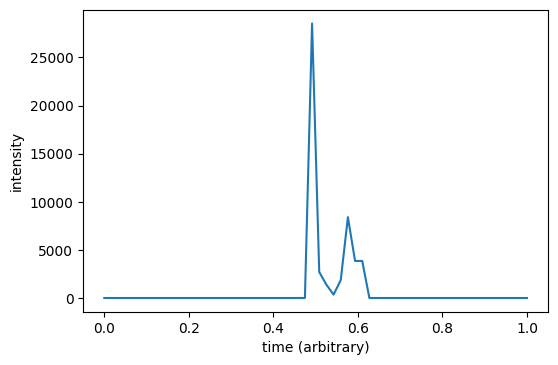

Enter classification (1=True Peak, 0=Artifact): 


In [ ]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,X_syn,y_syn,200,1000,32,5,numVal = 10,numManualPerRound=5,inJupyter=True)

integ.save(datadir + "active/")

In [26]:
integ.load(datadir + "active/")

In [28]:
y_test_scores_active_syn = integ.classifyMatrix(X_labeled)

4/4 [==============================] - 0s 3ms/step


In [29]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=0.5)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
8342/8342 [==============================] - 14s 2ms/step


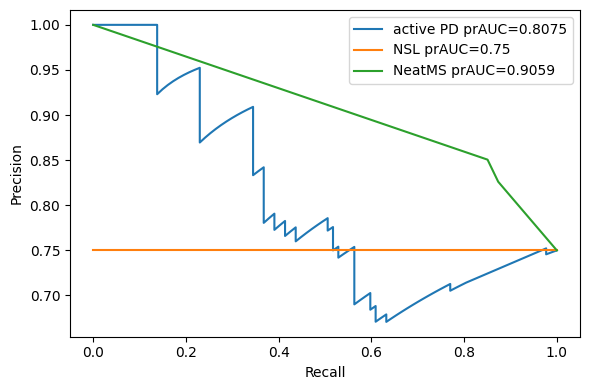

In [32]:
makePRCPlot(y_test_scores_active_syn[:,1],y_labeled[:,1],noSkill=True,label="active PD")
makePRCPlot(y_test_scores_neat_ms,y_labeled[:,1],noSkill=False,label="NeatMS")
#makePRCPlot(y_test_scores_neat_ms_TL,y_labeled[:,1],noSkill=False,label="NeatMS_TL")

plt.tight_layout()
plt.savefig(datadir+"PRC.png",dpi=300)

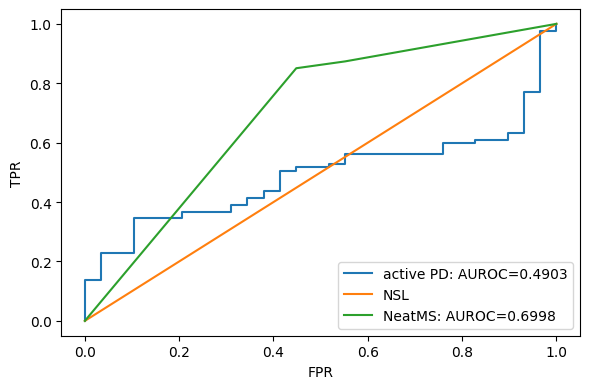

In [33]:
makeROCPlot(y_test_scores_active_syn[:,1],y_labeled[:,1],noSkill=True,label="active PD")
makeROCPlot(y_test_scores_neat_ms,y_labeled[:,1],noSkill=False,label="NeatMS")
#makePRCPlot(y_test_scores_neat_ms_TL,y_labeled[:,1],noSkill=False,label="NeatMS_TL")

plt.tight_layout()
plt.savefig(datadir+"PRC.png",dpi=300)

In [41]:
acc_results = pd.DataFrame.from_dict({"active PD":met.accuracy_score(y_labeled[:,1],y_test_scores_active_syn[:,1] > 0.5),
                                     "NeatMS":met.accuracy_score(y_labeled[:,1],y_test_scores_neat_ms > 0.25)},orient="index")
acc_results.to_csv(datadir + "accuracy_results.csv")

In [42]:
acc_results

0
active PD  0.482759
NeatMS     0.767241

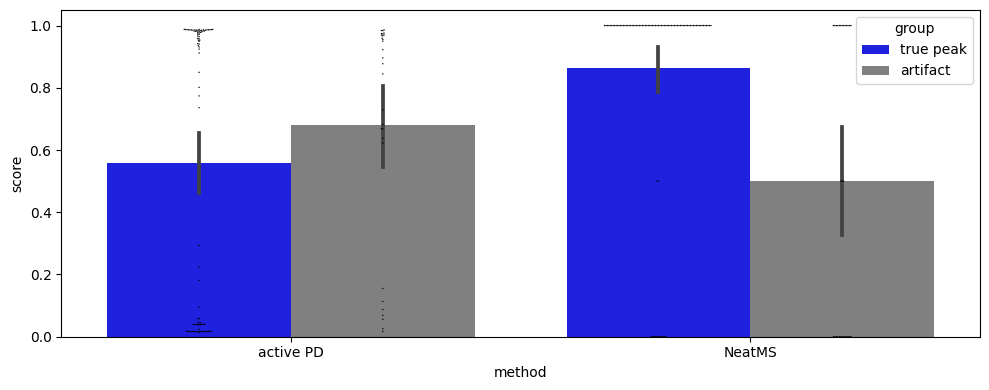

In [34]:
plt_df = {}
for x in range(len(y_labeled)):
    if y_labeled[x][1] > 0.5:
        plt_df[len(plt_df)] = {"method":"active PD","group":"true peak","score":y_test_scores_active_syn[x][1]}
        plt_df[len(plt_df)] = {"method":"NeatMS","group":"true peak","score":y_test_scores_neat_ms[x]}

    else:
        plt_df[len(plt_df)] = {"method":"active PD","group":"artifact","score":y_test_scores_active_syn[x][1]}
        plt_df[len(plt_df)] = {"method":"NeatMS","group":"artifact","score":y_test_scores_neat_ms[x]}

plt_df = pd.DataFrame.from_dict(plt_df,orient="index")
plt.figure(figsize=(10,4))
#sb.violinplot(data=plt_df,x="method",y="score",hue="group",cut=0,palette={"true peak":"blue","artifact":"grey"})
sb.barplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"blue","artifact":"grey"})
sb.swarmplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"black","artifact":"black"},dodge=True,s=1,legend=False)
plt.tight_layout()
plt.savefig(datadir+"bar.png",dpi=300)

In [35]:
y = integ.classifyMatrix(X)

8342/8342 [==============================] - 13s 2ms/step


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


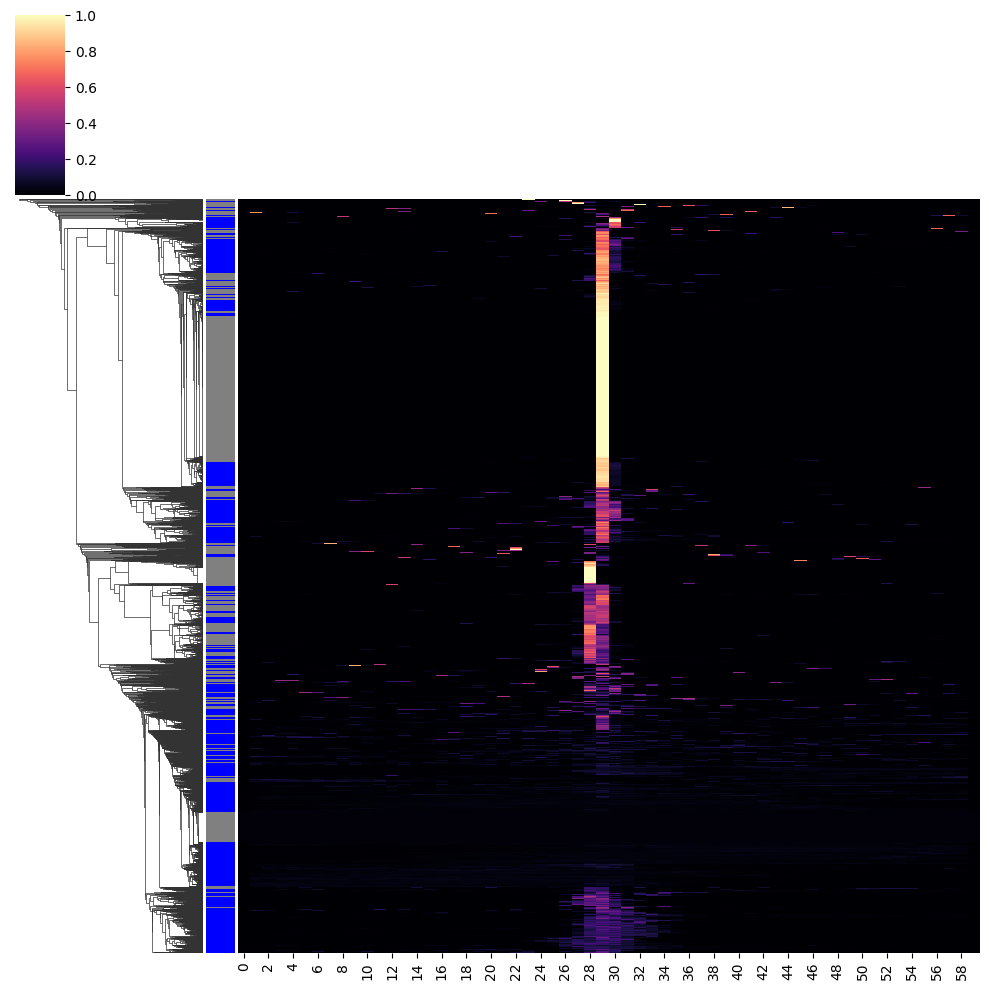

In [36]:
def tmp(val):
    if val > 0.5:
        return "blue"
    return "grey"
row_colors = [tmp(x) for x in y[:len(peakList),1]]
sb.clustermap(PeakDetective.normalizeMatrix(X[:len(peakList)]),col_cluster=False,yticklabels=False,cmap="magma",vmin=0.0,vmax=1.0,row_colors=row_colors)

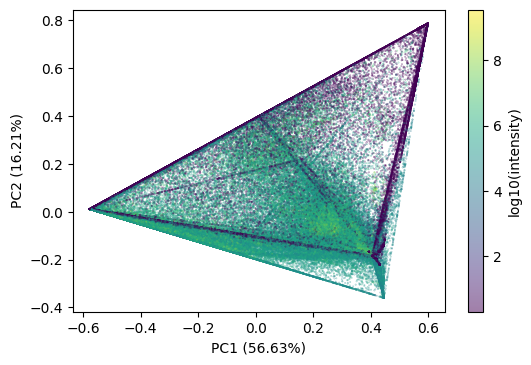

In [37]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))
plt.colorbar(label="log10(intensity)")

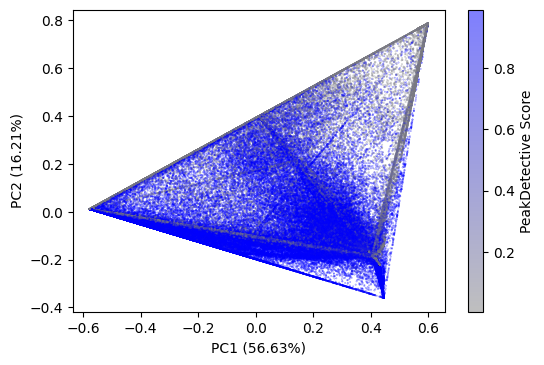

In [38]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))

plt.colorbar(label="PeakDetective Score")

Text(0, 0.5, '% of features')

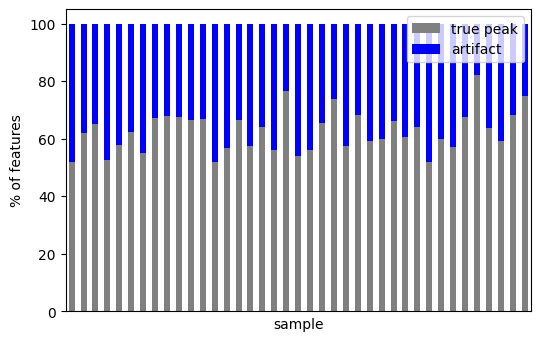

In [39]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > 0.5:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['sample10_dilution_1_2.mzML', 'sample11_dilution_100.mzML', 'sample12_dilution_7_5.mzML', 'sample13_dilution_1_8.mzML', 'sample14_dilution_3.mzML', 'sample15_dilution_15.mzML', 'sample16_dilution_50.mzML', 'sample17_dilution_20.mzML', 'sample18_dilution_50.mzML', 'sample19_dilution_5.mzML', 'sample1_dilution_1_4.mzML', 'sample20_dilution_1_6.mzML', 'sample21_dilution_100.mzML', 'sample22_dilution_7_5.mzML', 'sample23_dilution_2.mzML', 'sample24_dilution_50.mzML', 'sample25_dilution_10.mzML', 'sample26_dilution_1_2.mzML', 'sample27_dilution_2.mzML', 'sample28_dilution_15.mzML', 'sample29_dilution_10.mzML', 'sample2_dilution_5.mzML', 'sample30_dilution_100.mzML', 'sample31_dilution_1_6.mzML', 'sample32_dilution_1_8.mzML', 'sample33_dilution_1_2.mzML', 'sample34_dilution_20.mzML', 'sample35_dilution_7_5.mzML', 'sample36_dilution_1_4.mzML', 'sample37_dilution_1_8.mzML', 'sample38_dilution_3.mzML', 'sample39_dilution_2.mzML', 'sample3_dilution_20.mzML', 'sample40_dilution_3.mzML', 'sample4

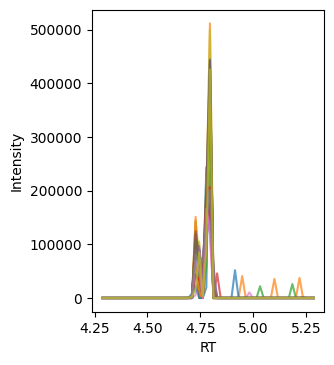

In [46]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = files[0]
print(files)
inds = list(peak_curated.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] > 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

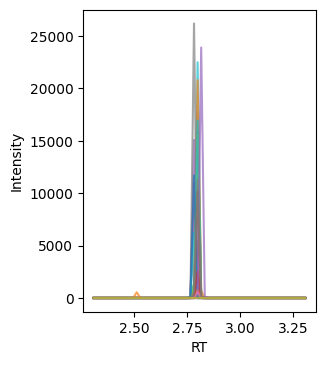

In [47]:
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] < 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [54]:
print(confusion_matrix(y_labeled[:,1],y_test_scores_neat_ms > 0.5))
print(met.accuracy_score(y_labeled[:,1],y_test_scores_neat_ms > 0.5))

[[16 13]
 [13 74]]
0.7758620689655172


In [55]:
print(confusion_matrix(y_labeled[:,1],y_test_scores_active_syn[:,1] > 0.5))
print(met.accuracy_score(y_labeled[:,1],y_test_scores_active_syn[:,1] > 0.5))

[[ 5 24]
 [24 63]]
0.5862068965517241


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


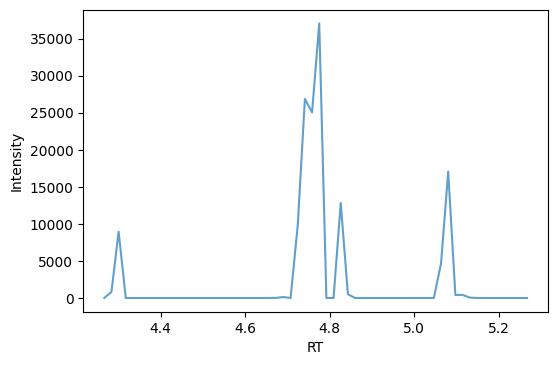

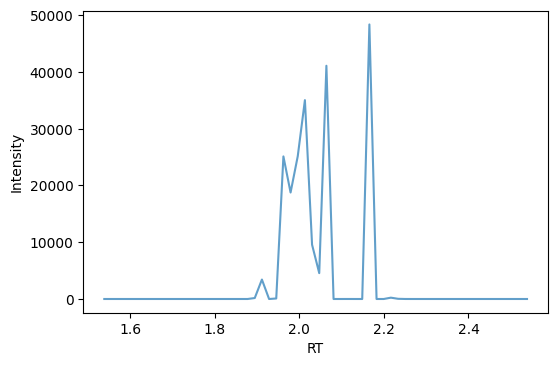

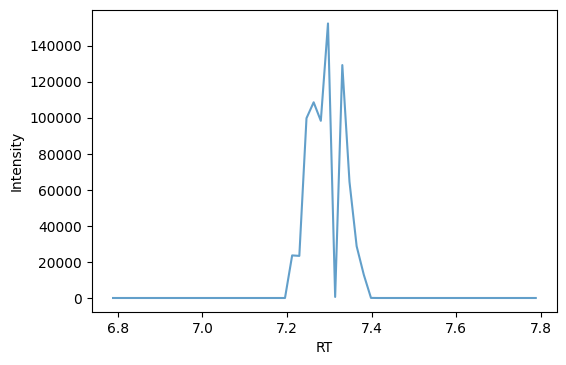

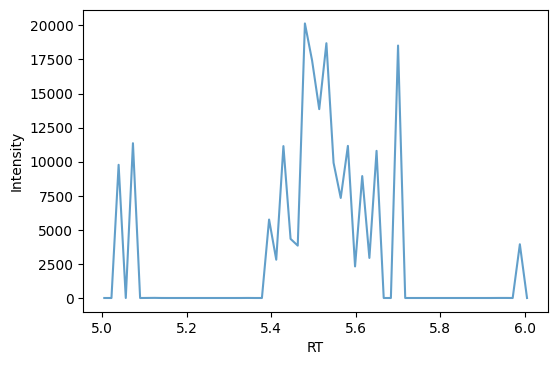

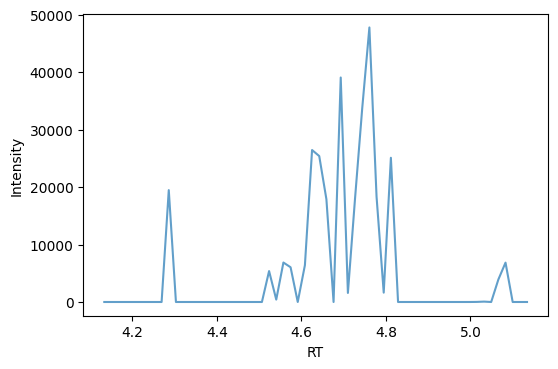

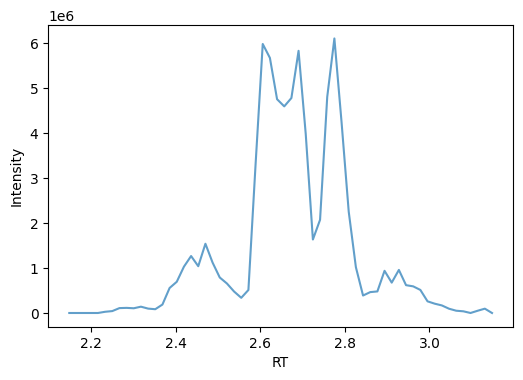

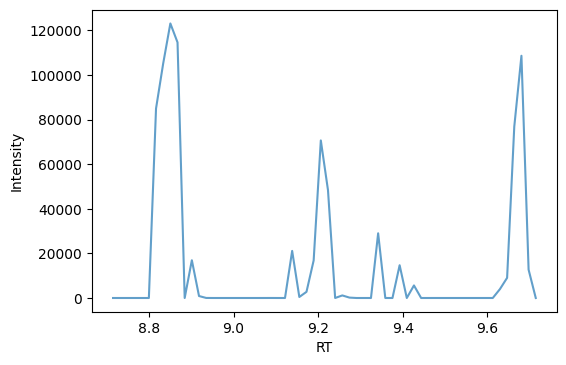

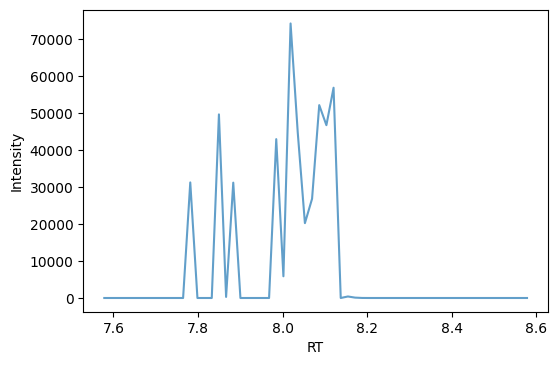

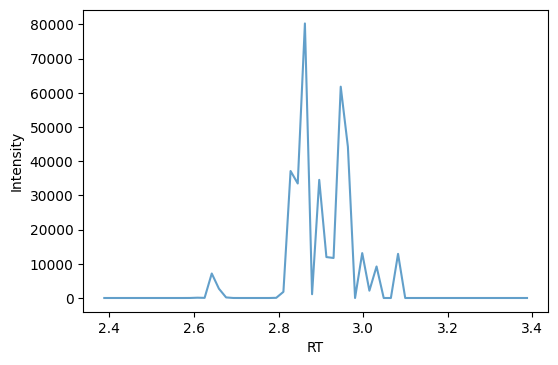

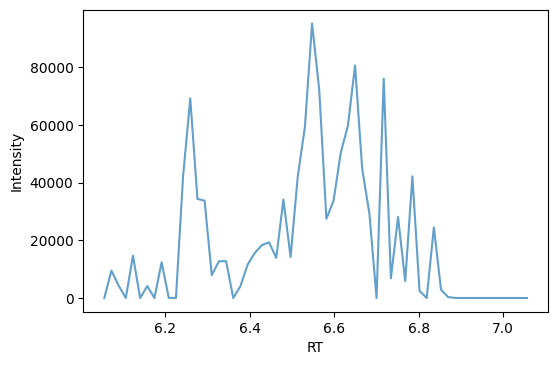

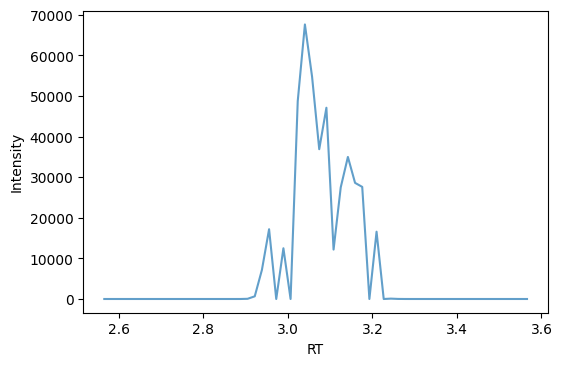

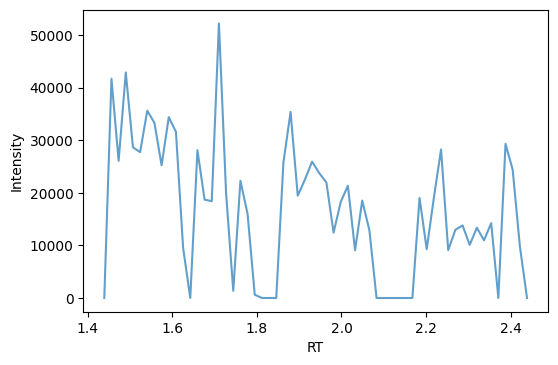

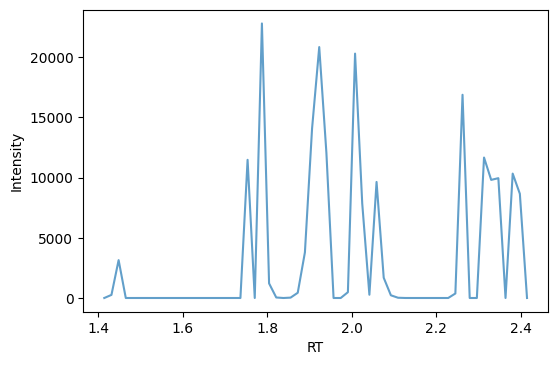

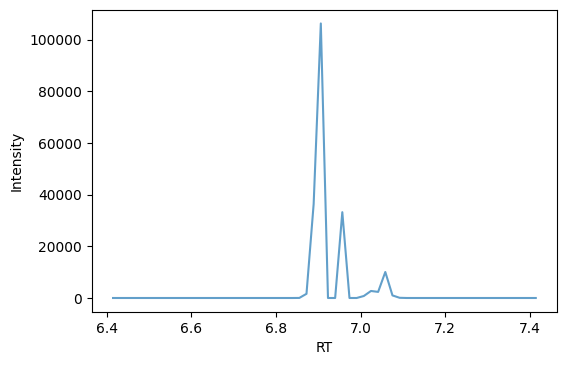

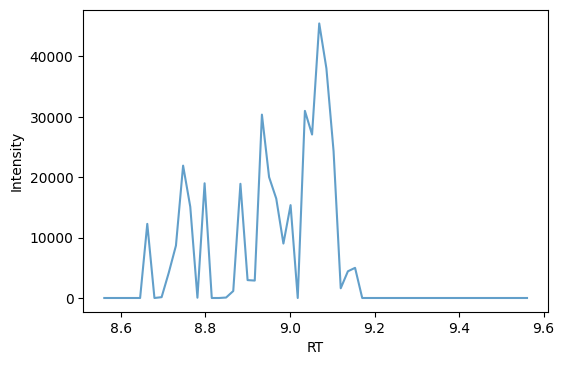

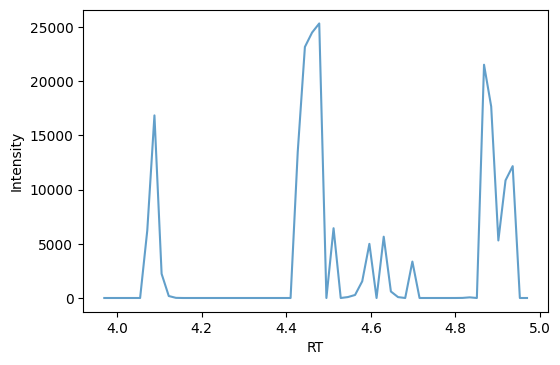

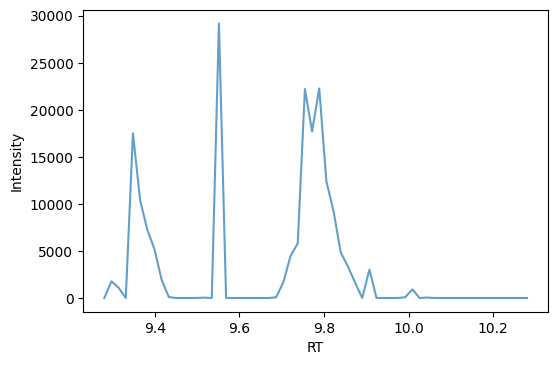

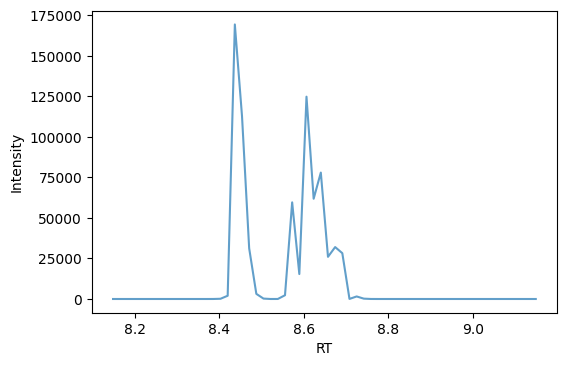

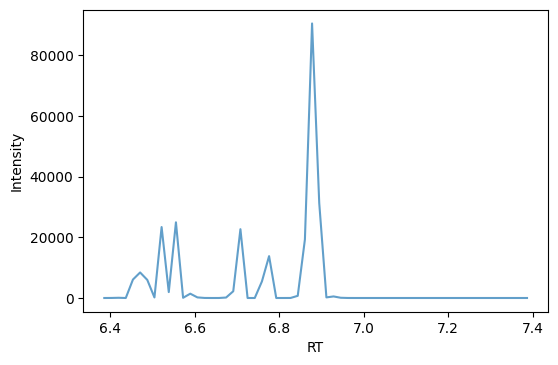

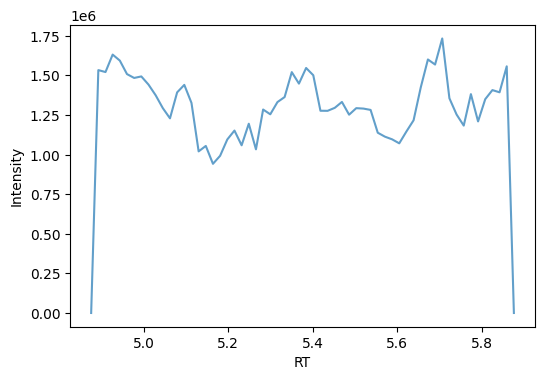

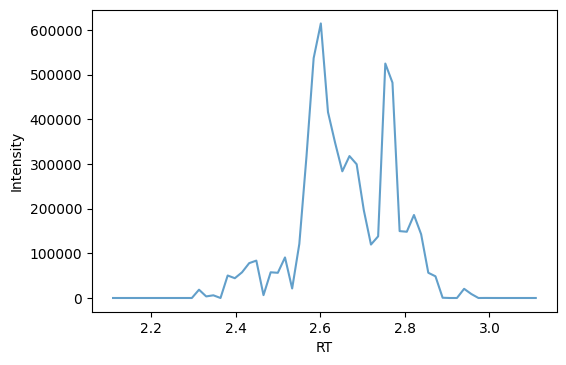

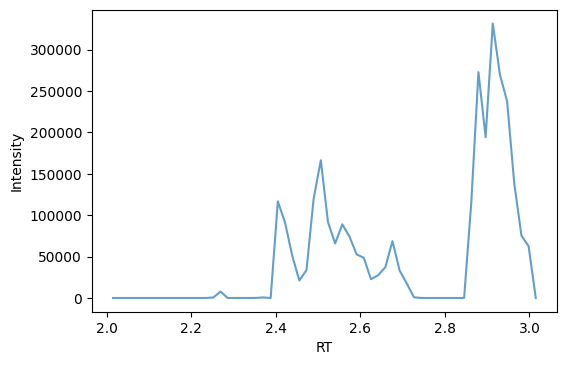

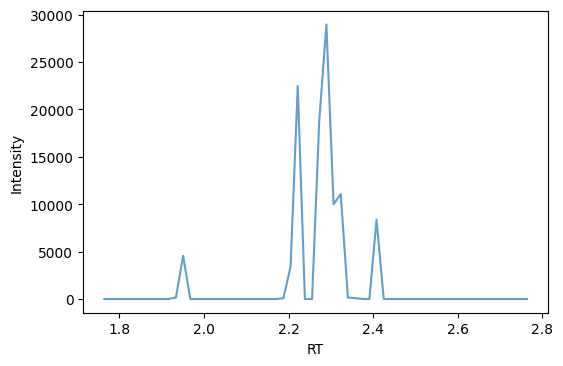

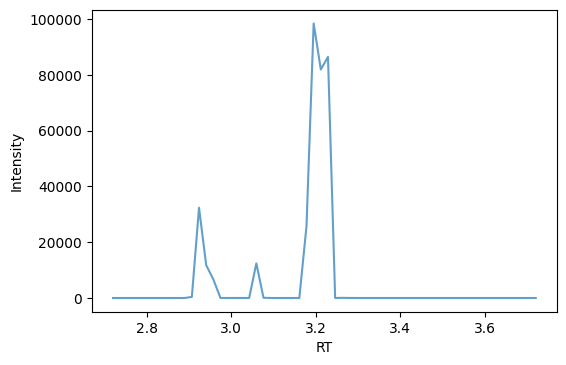

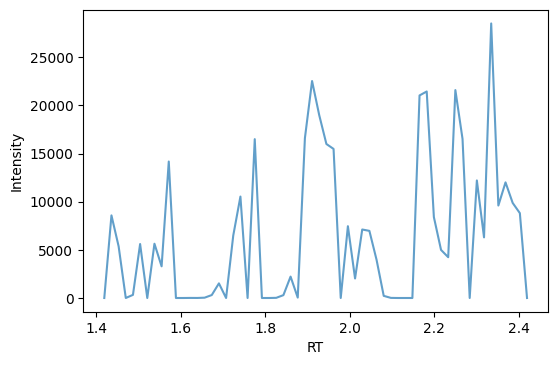

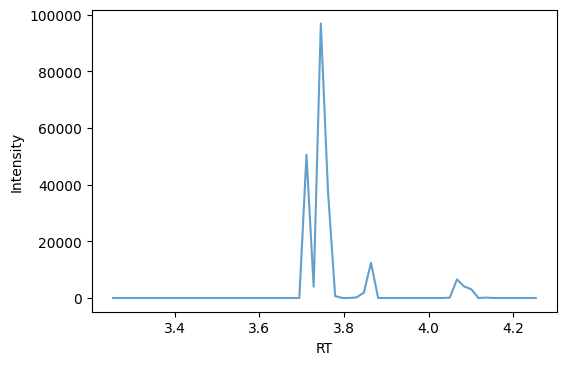

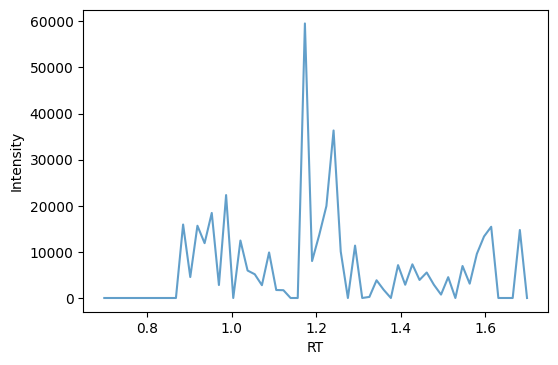

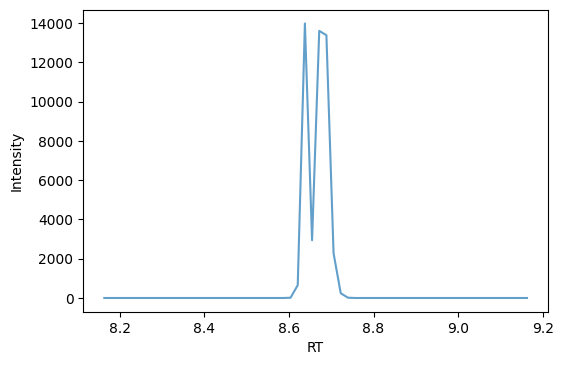

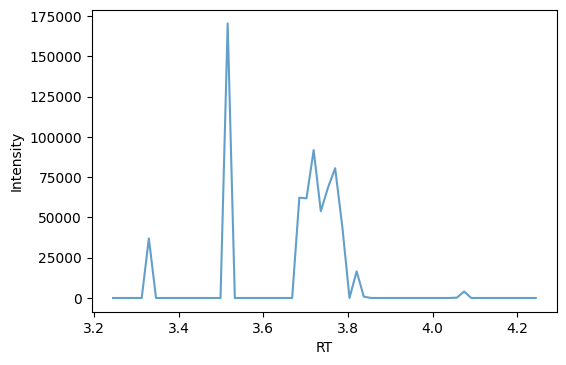

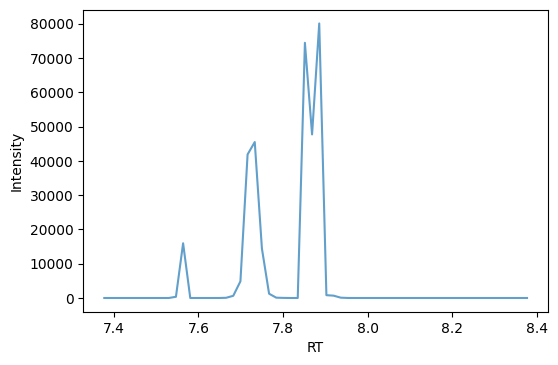

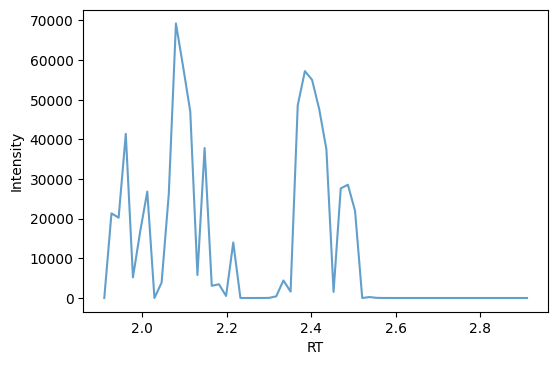

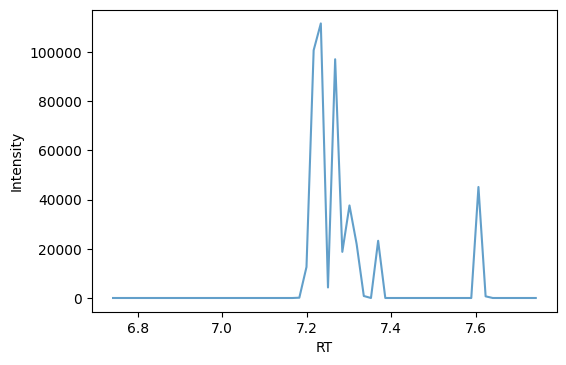

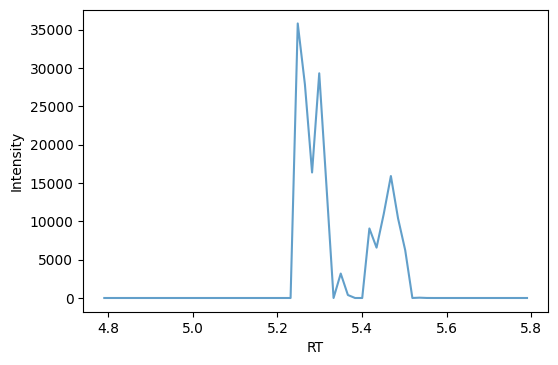

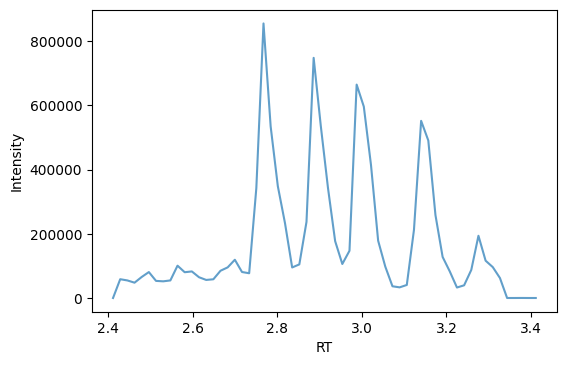

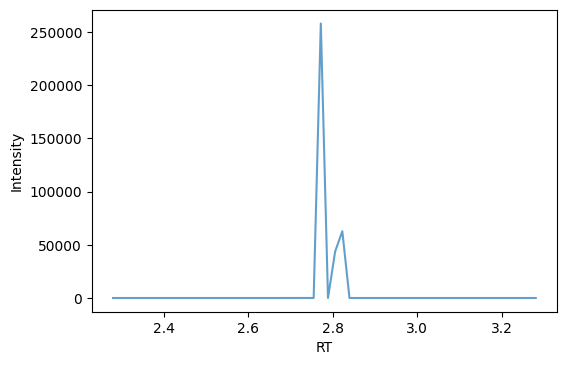

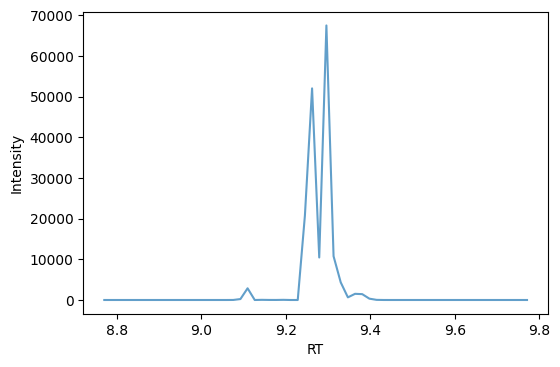

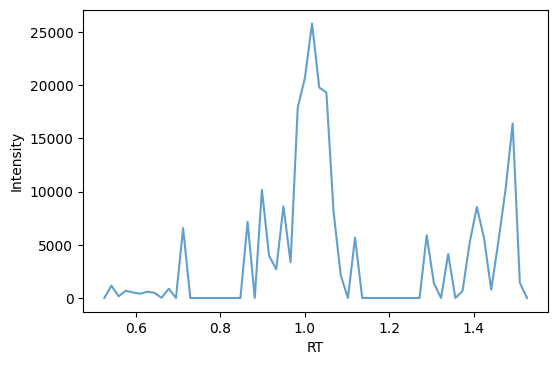

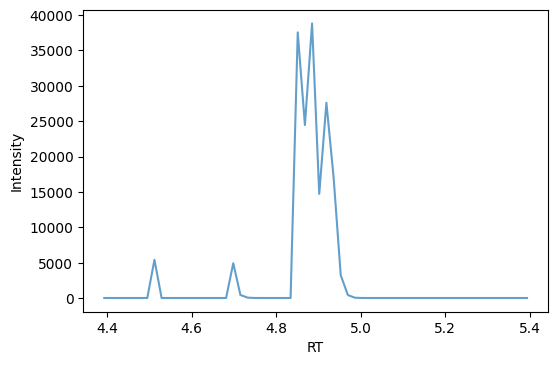

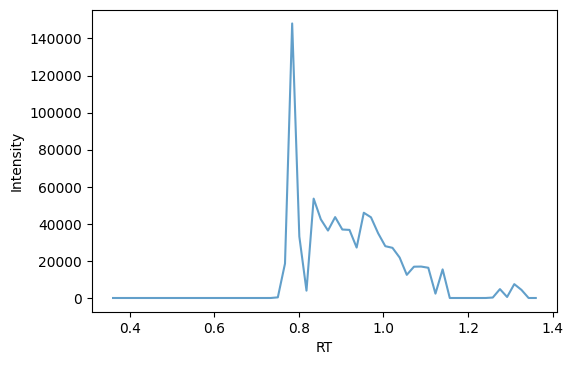

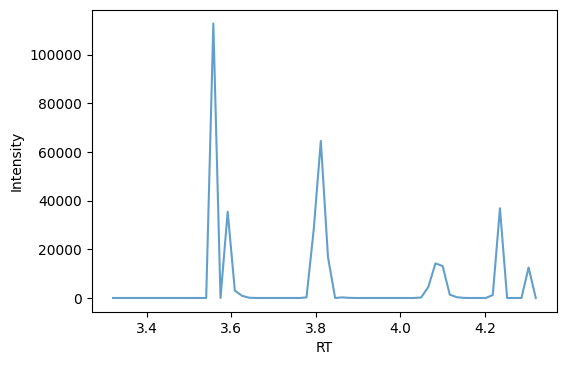

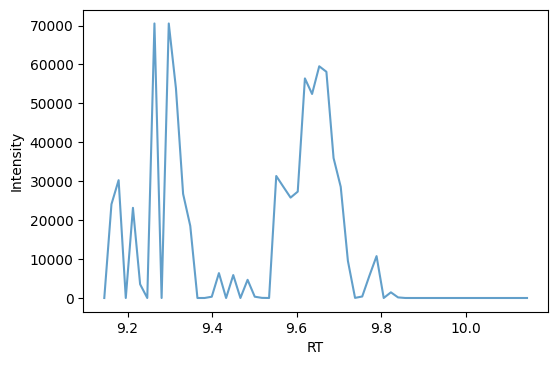

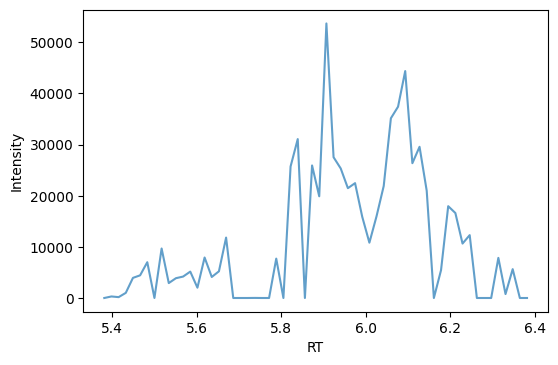

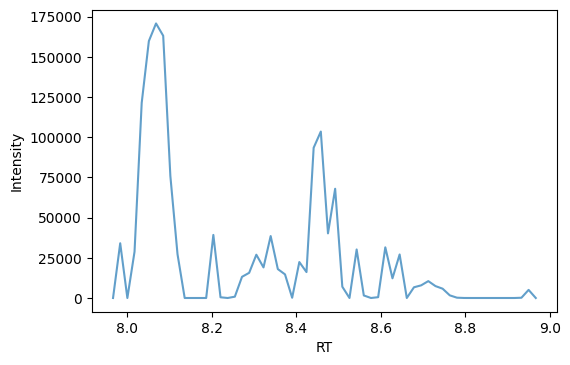

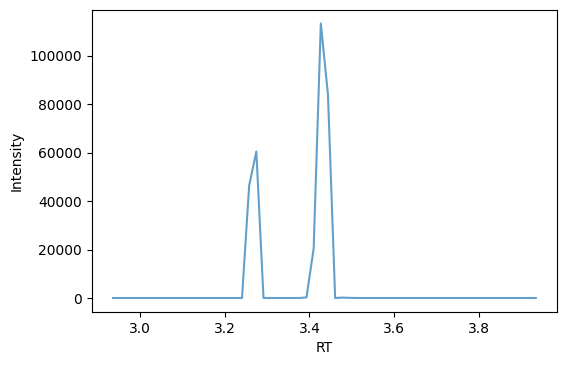

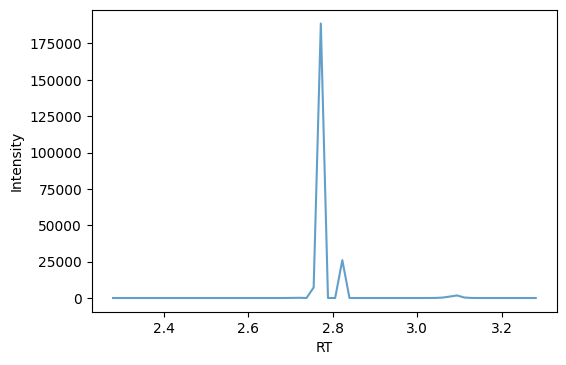

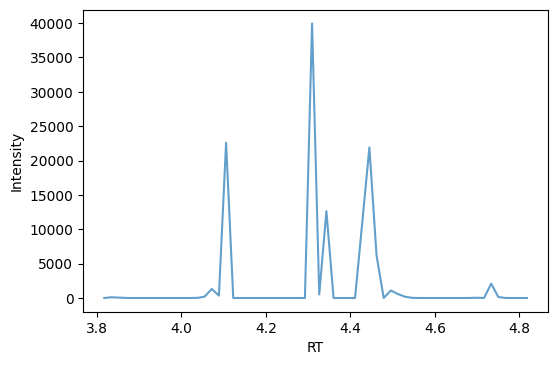

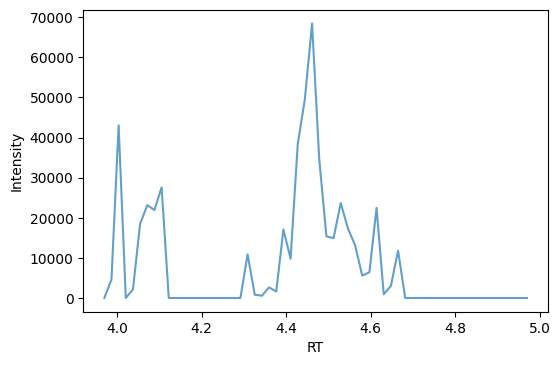

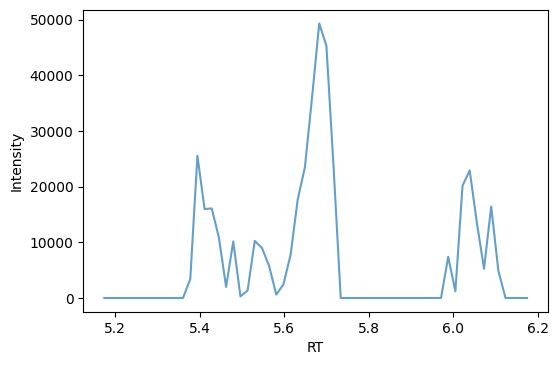

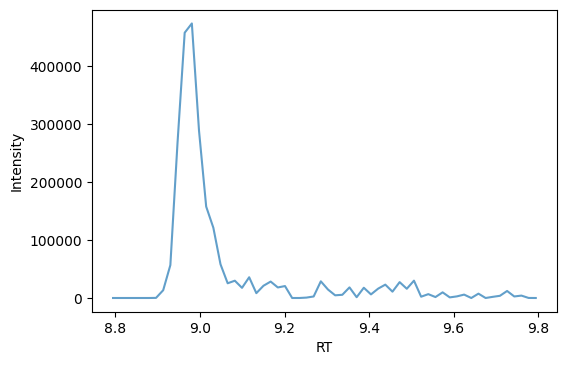

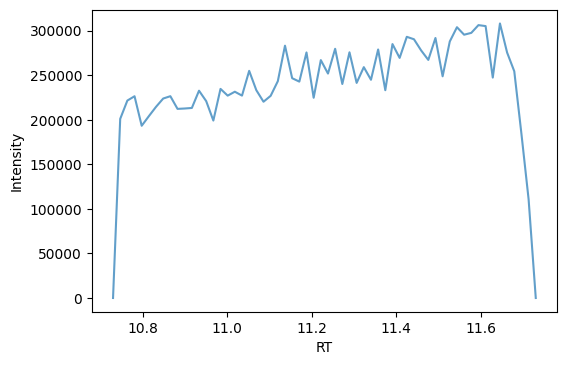

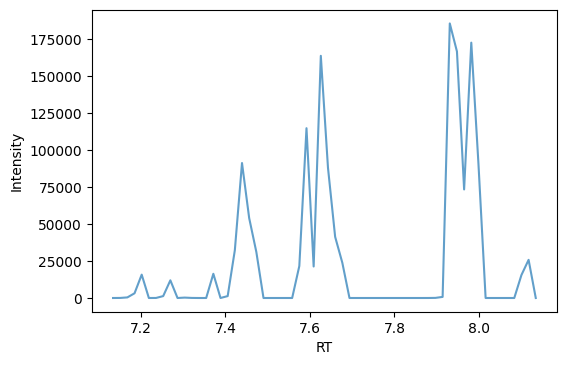

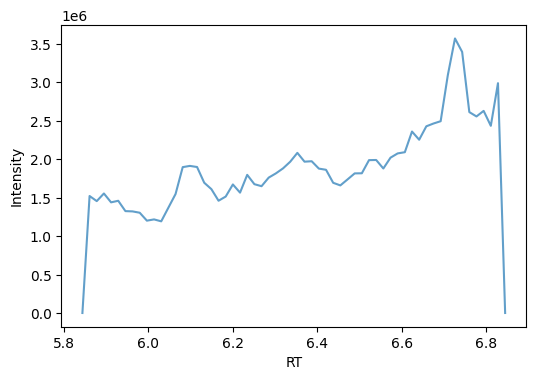

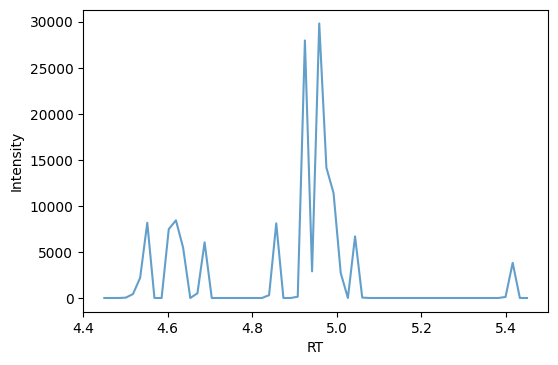

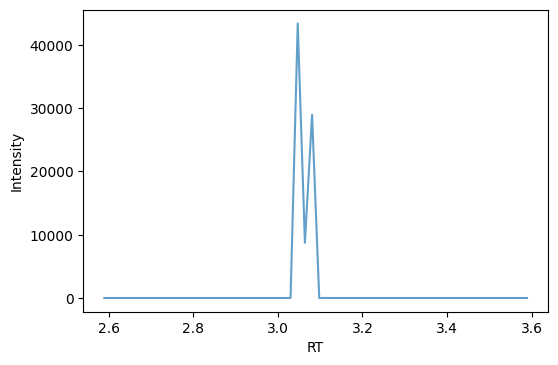

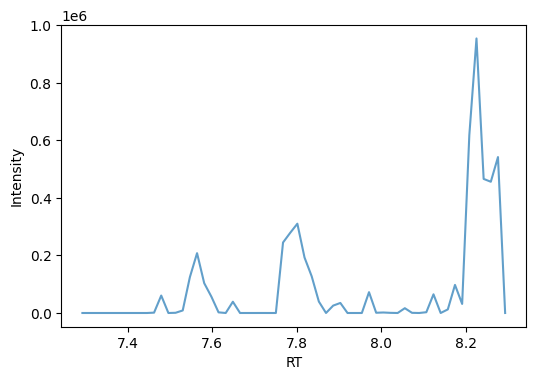

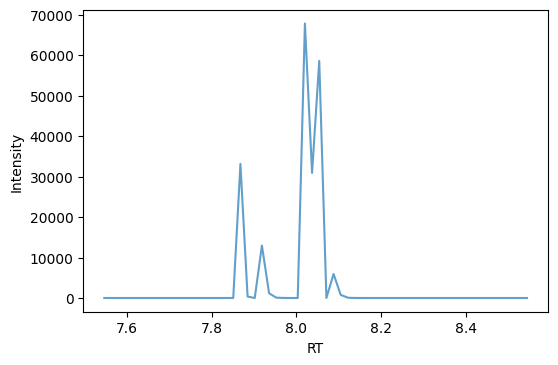

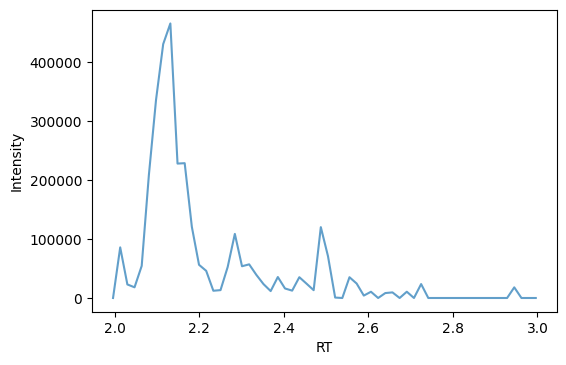

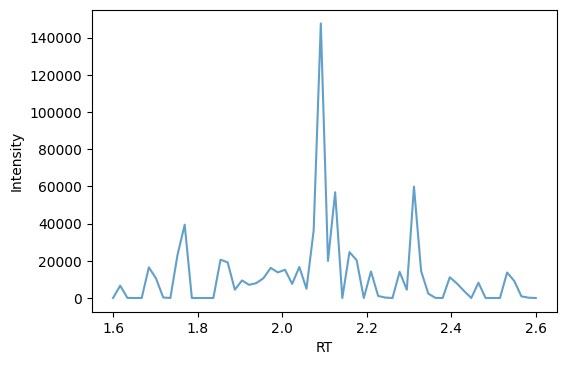

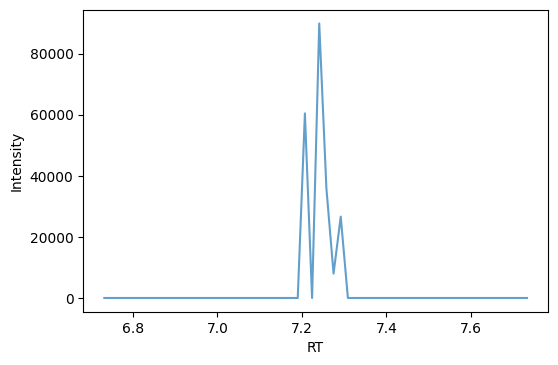

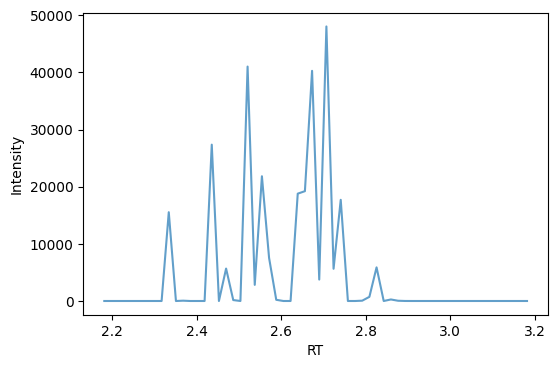

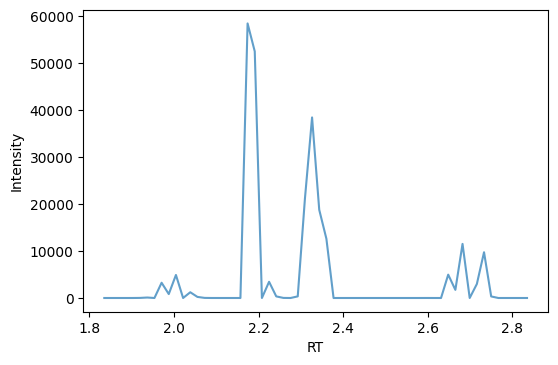

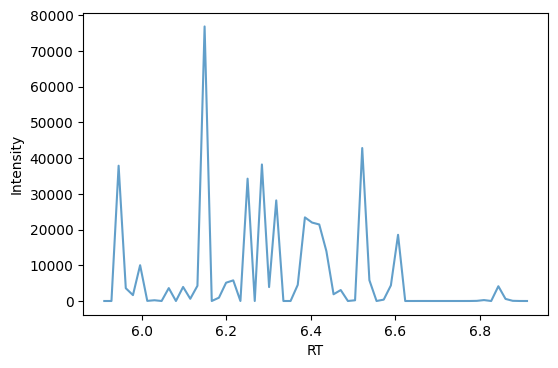

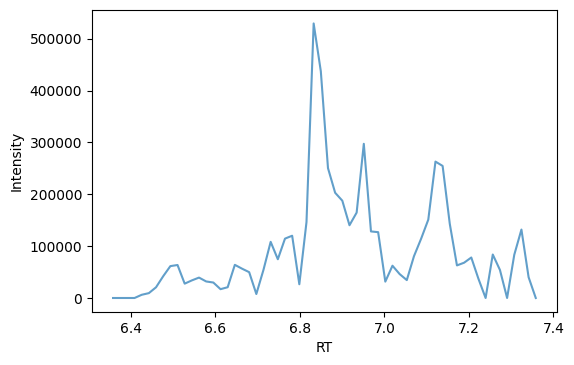

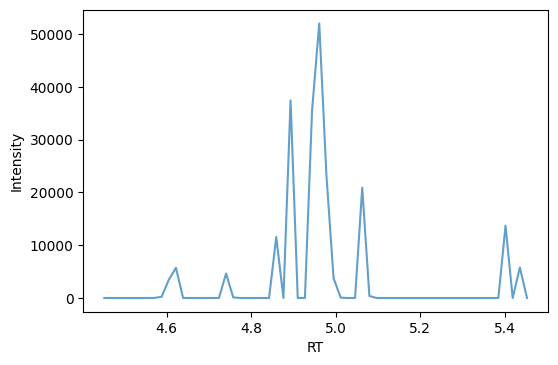

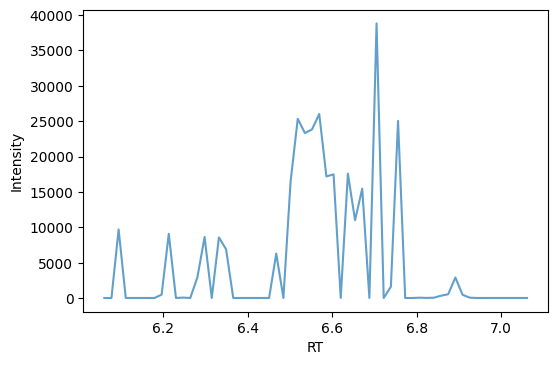

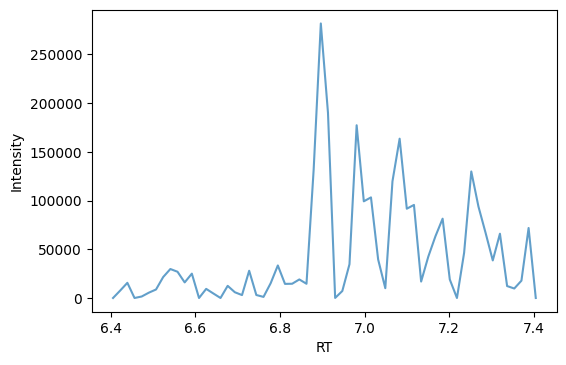

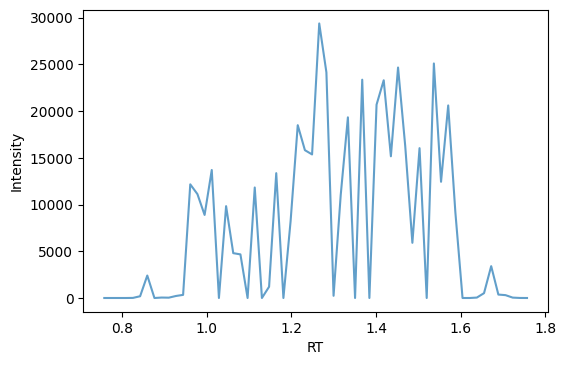

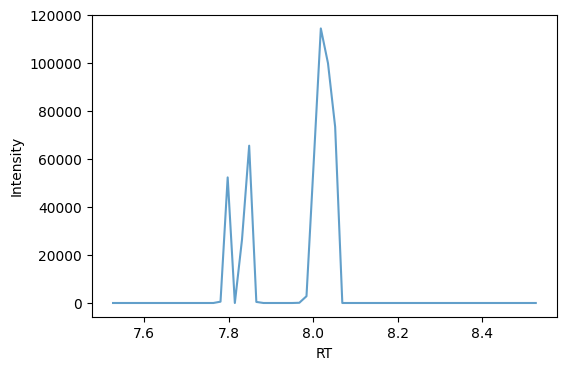

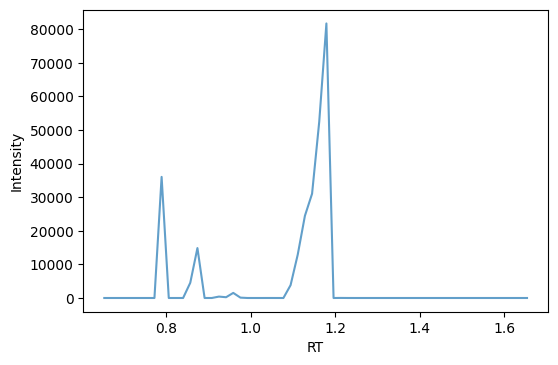

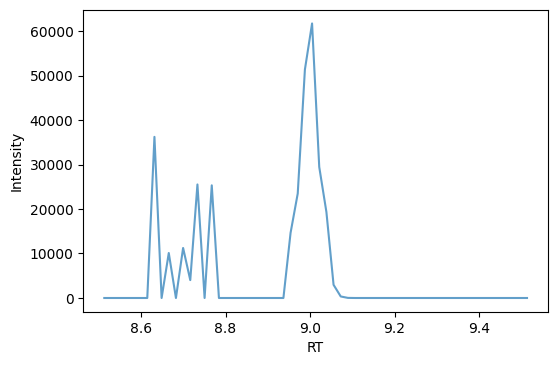

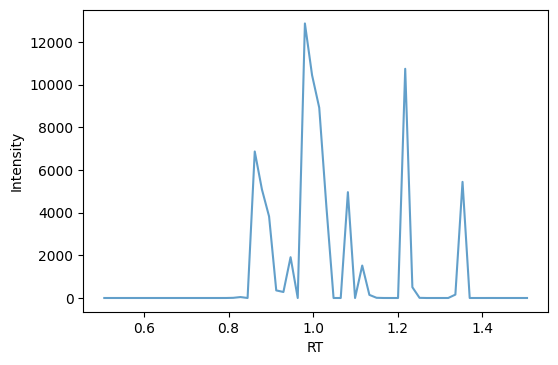

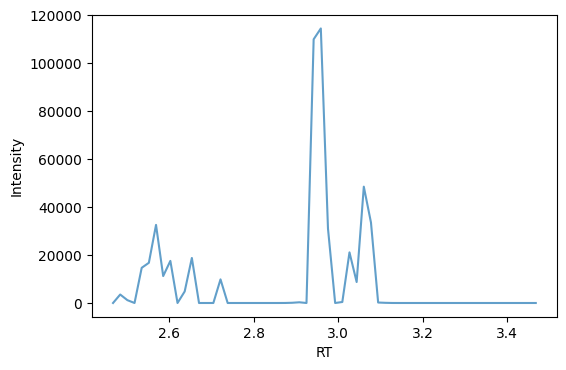

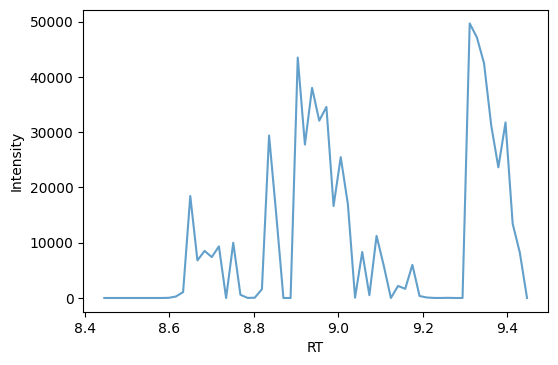

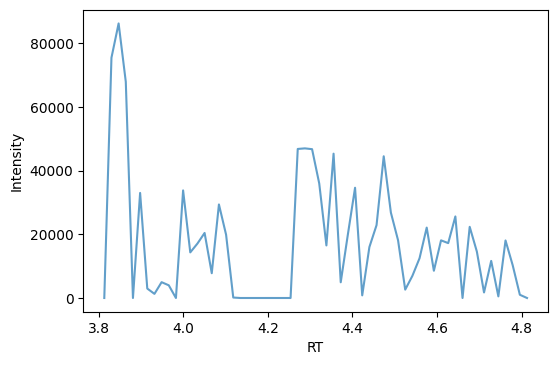

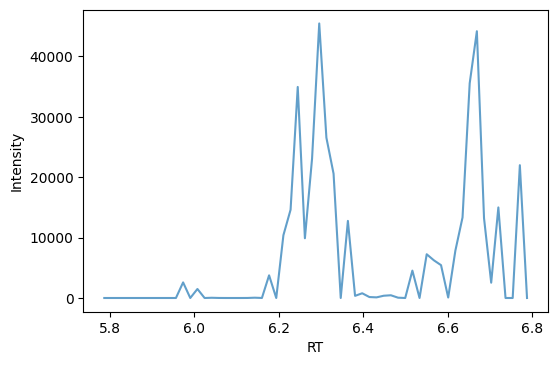

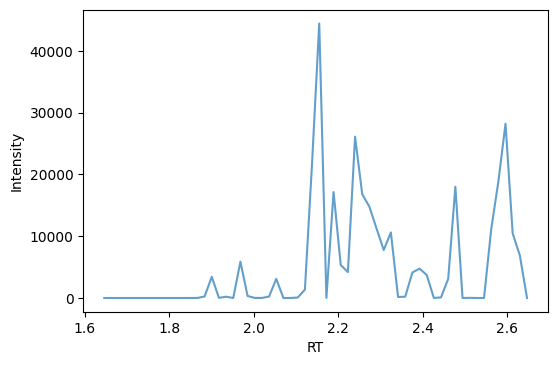

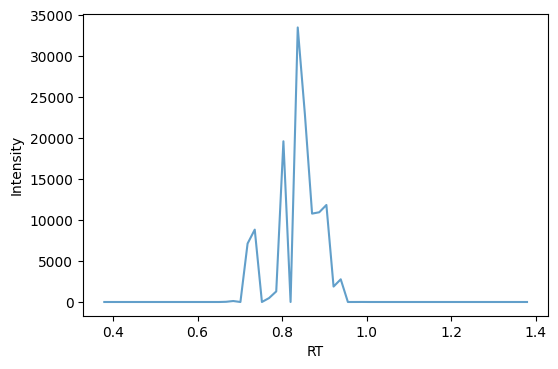

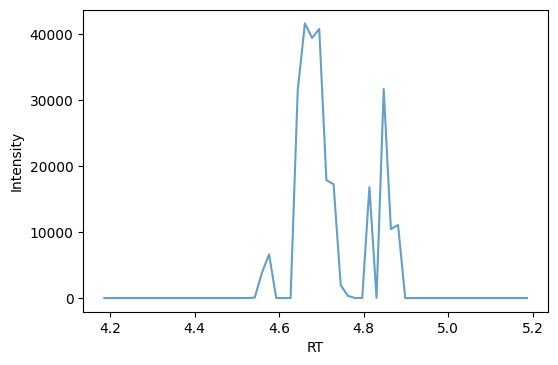

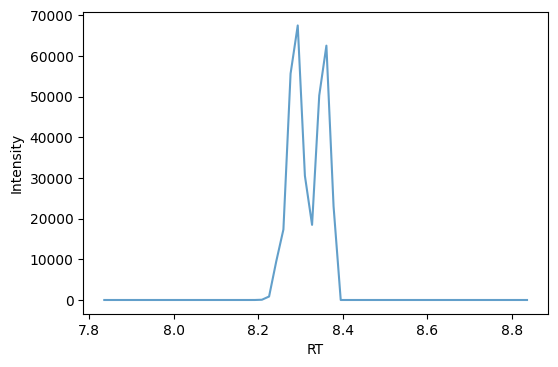

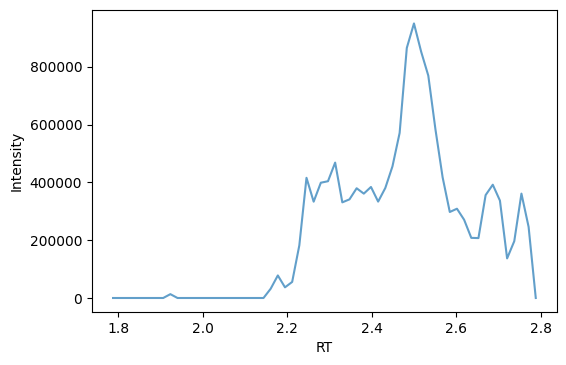

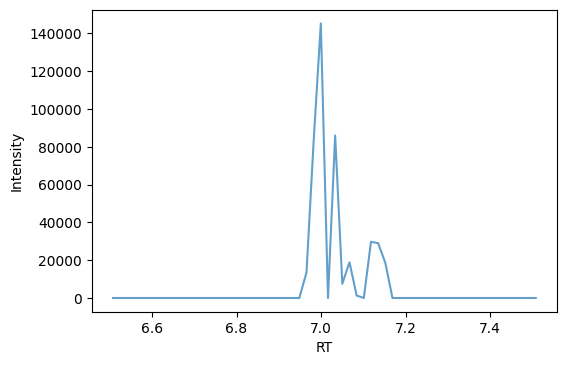

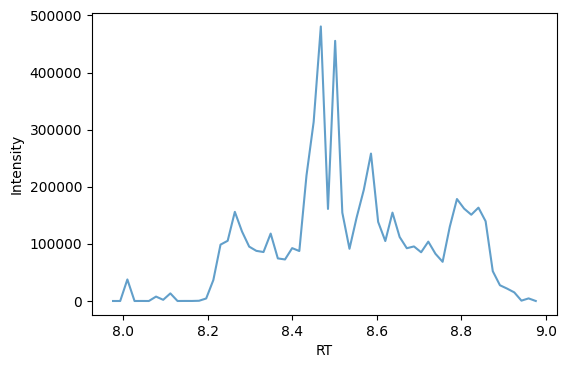

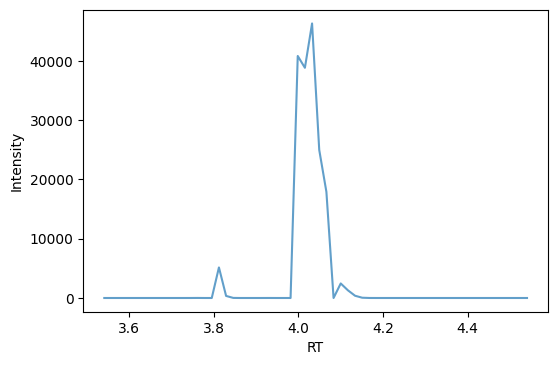

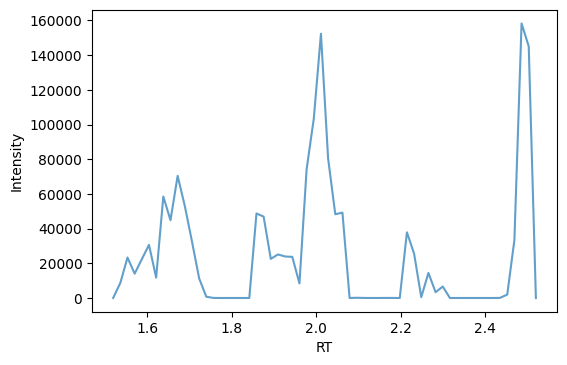

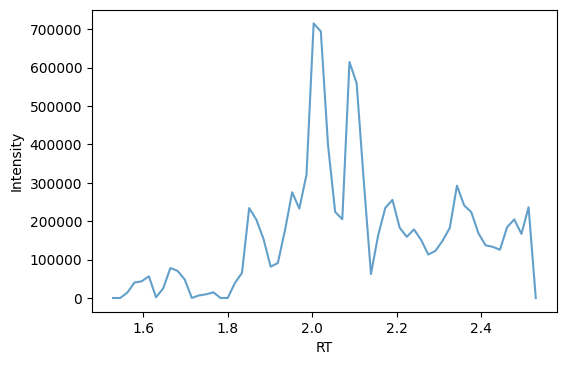

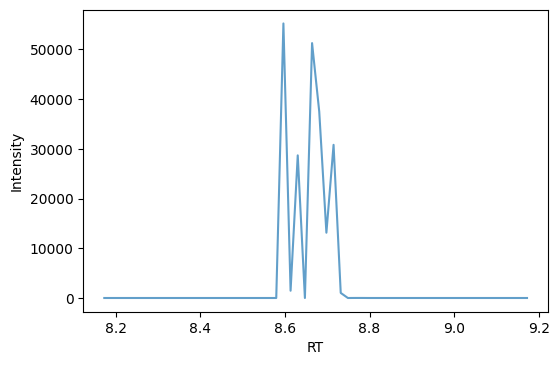

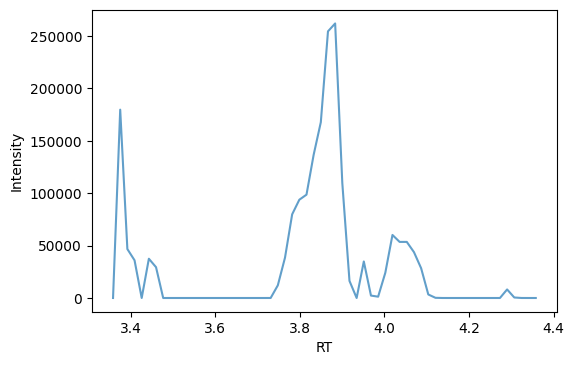

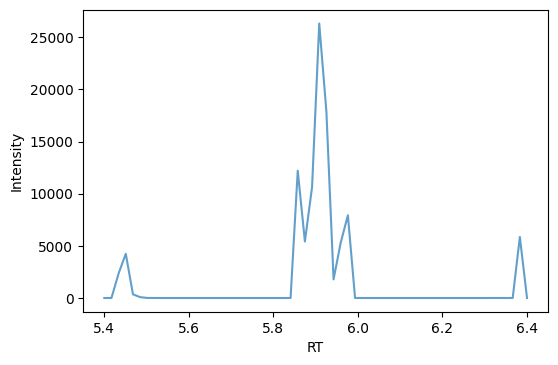

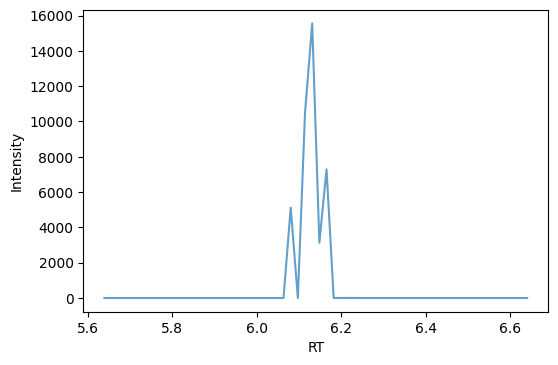

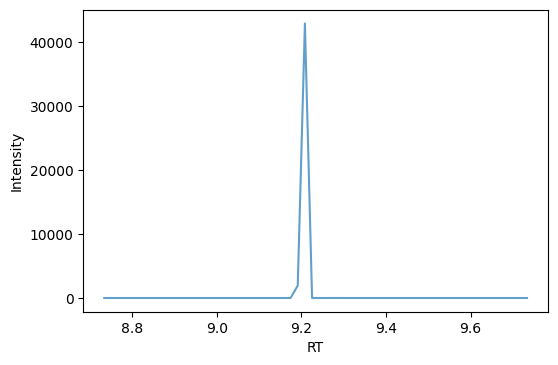

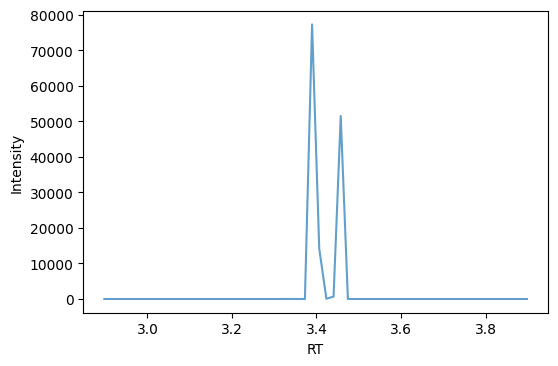

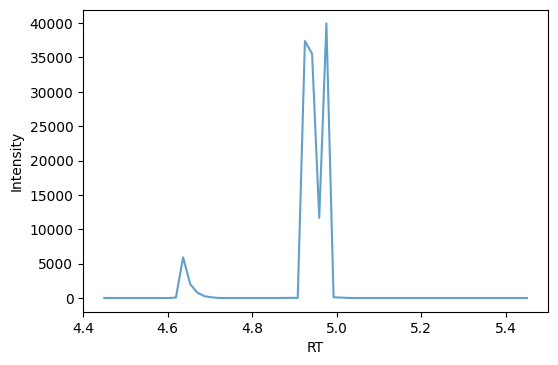

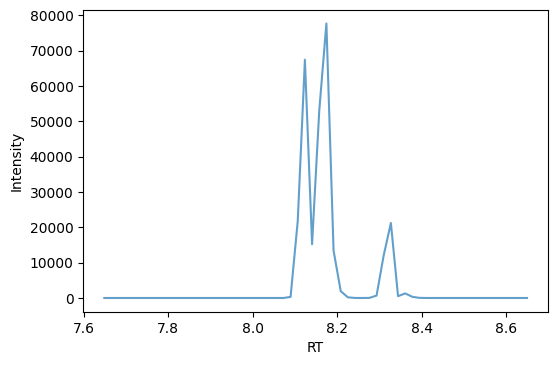

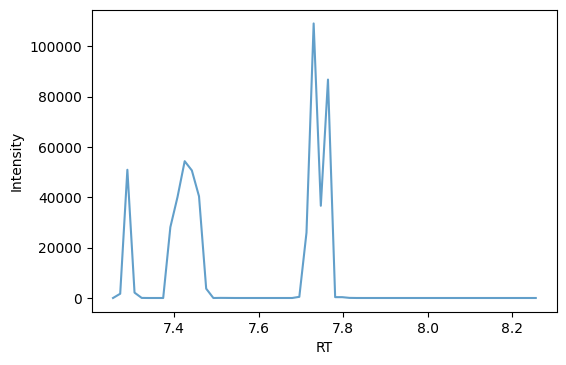

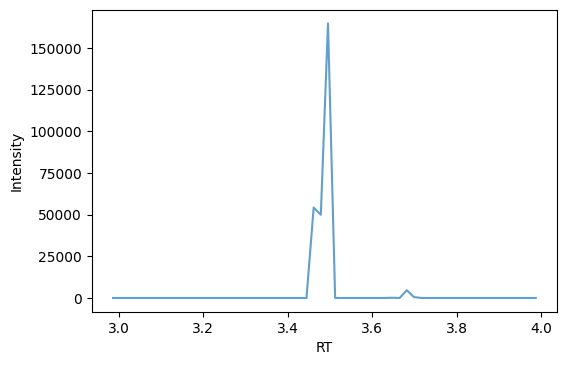

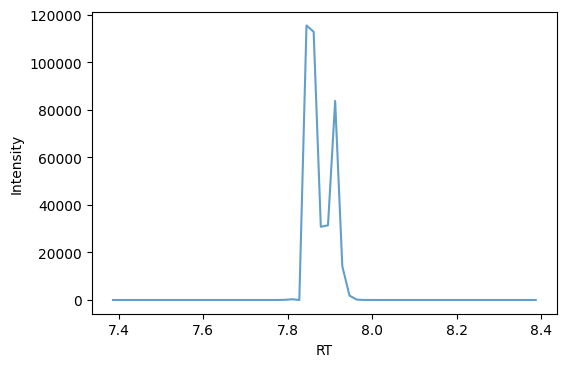

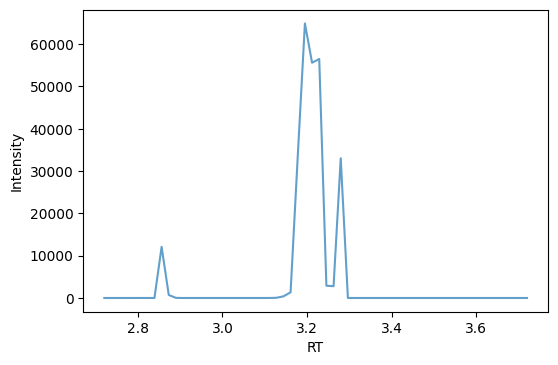

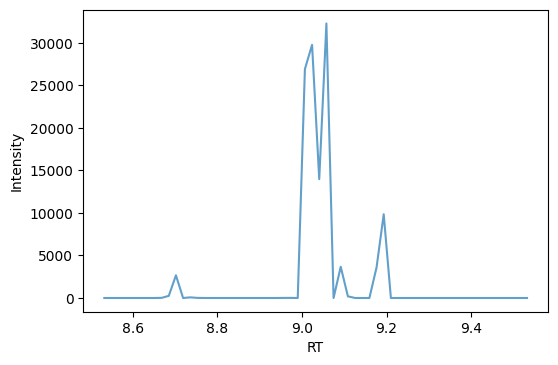

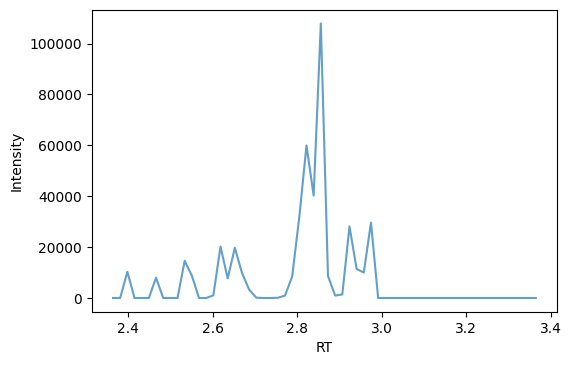

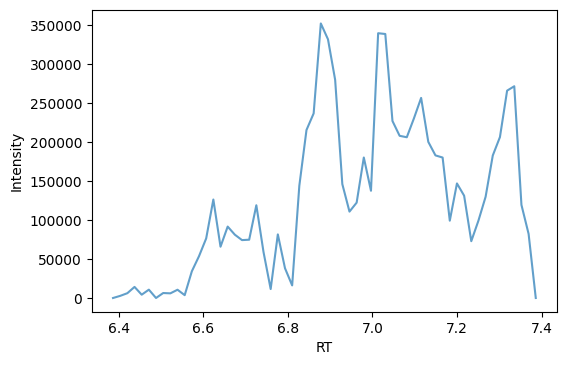

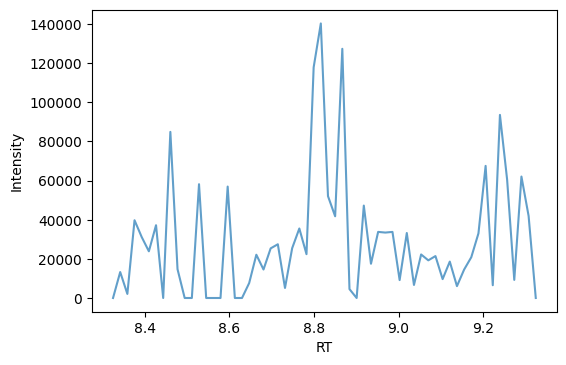

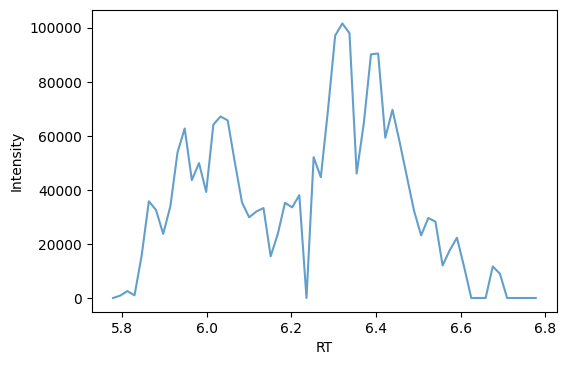

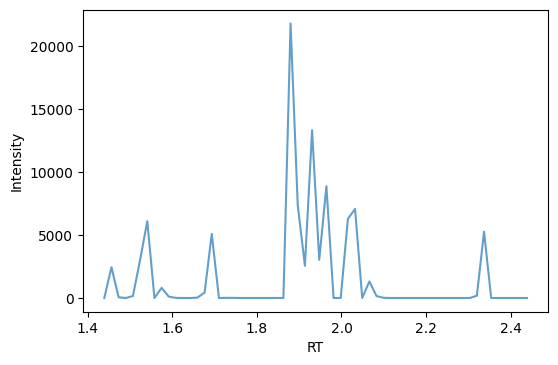

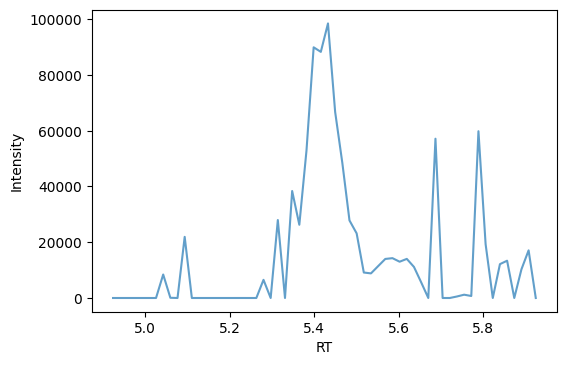

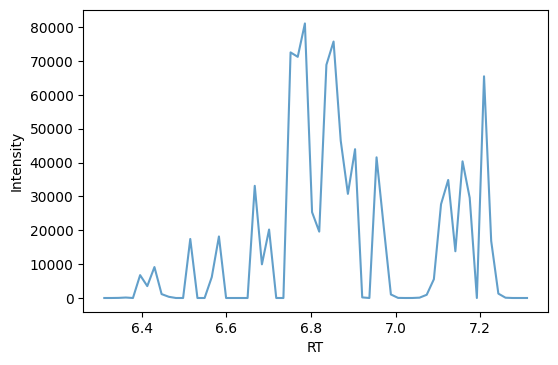

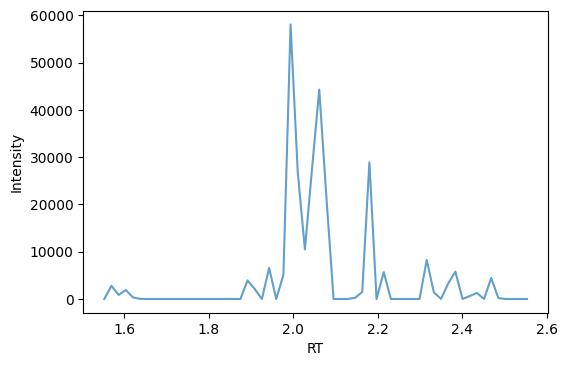

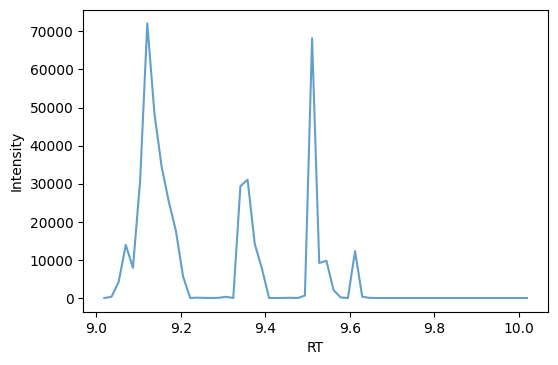

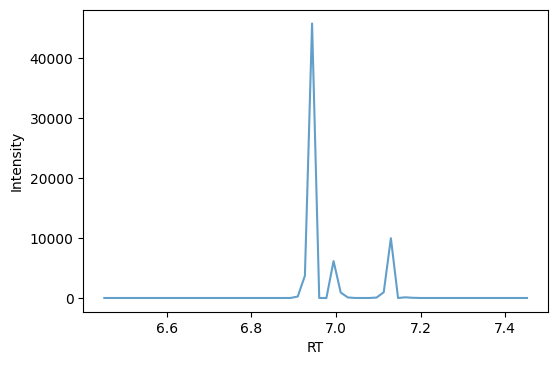

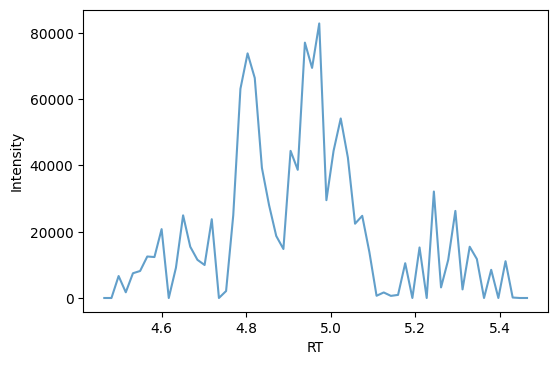

<Figure size 600x400 with 0 Axes>

In [124]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


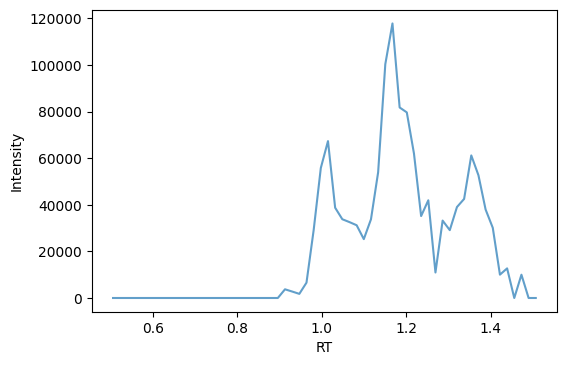

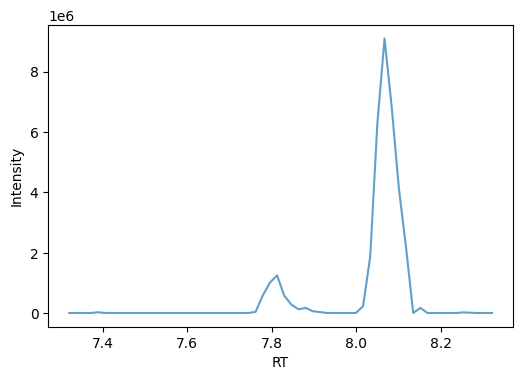

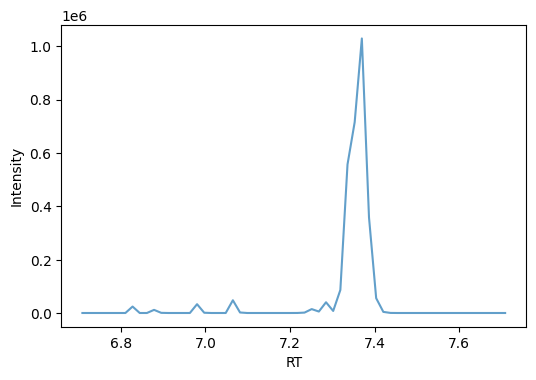

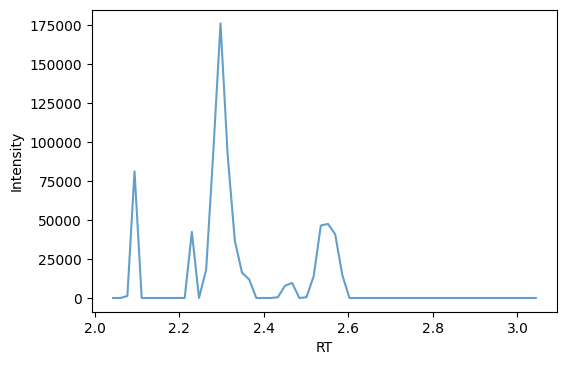

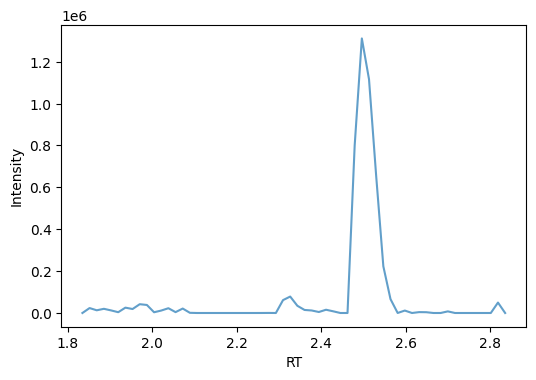

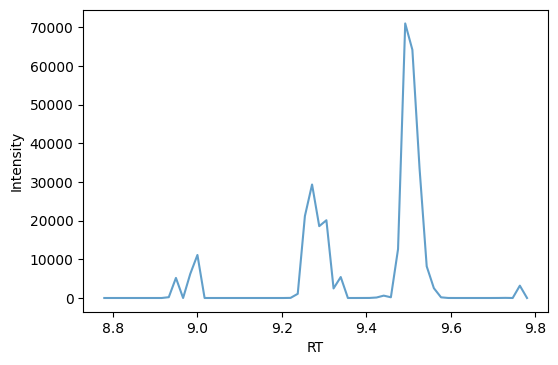

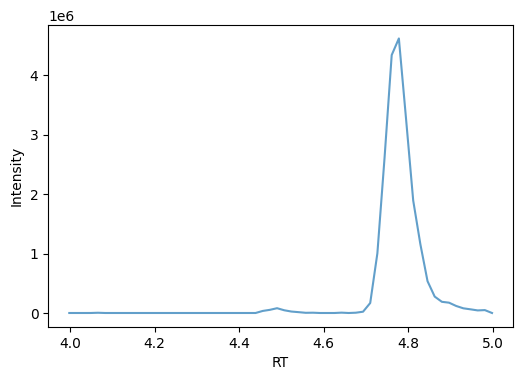

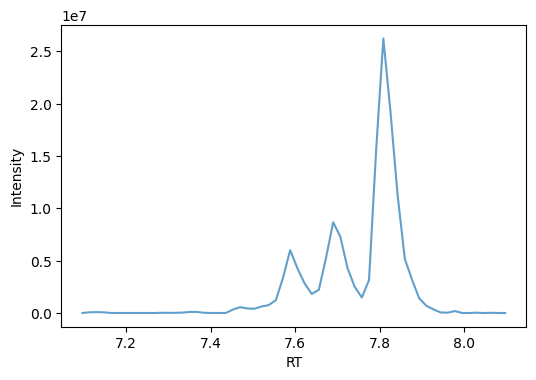

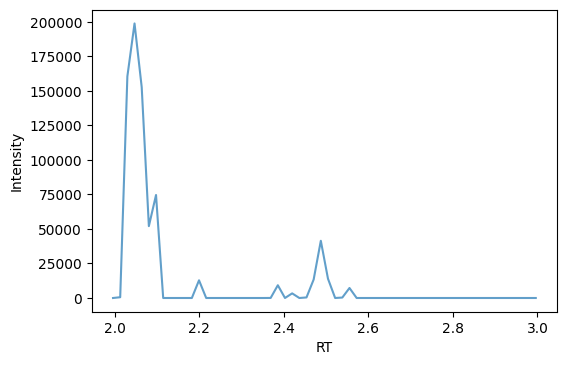

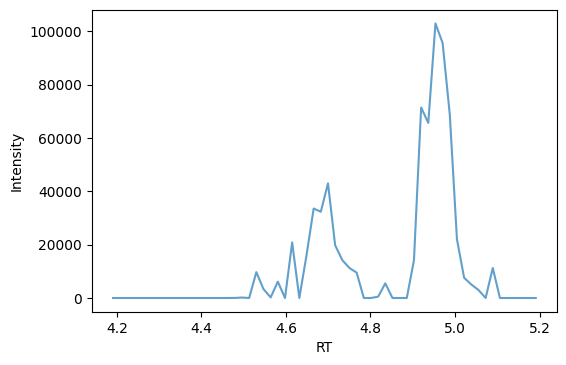

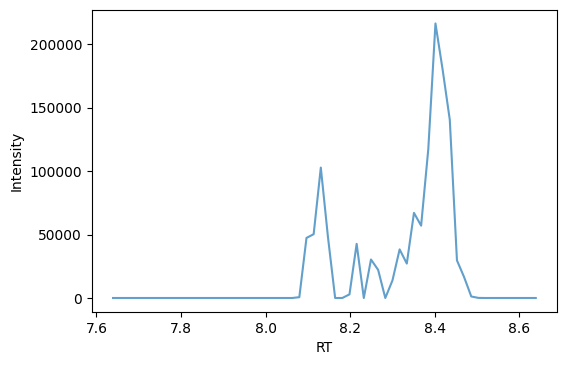

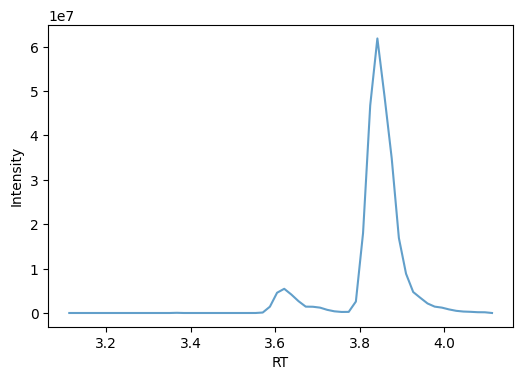

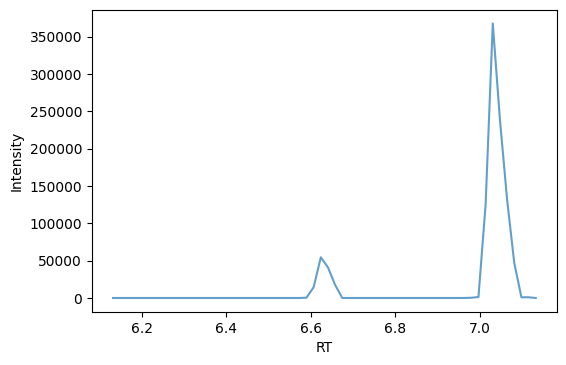

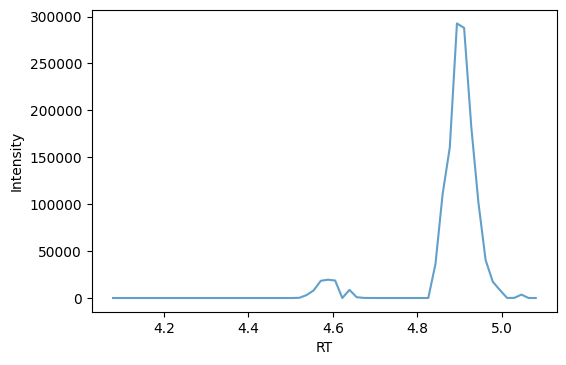

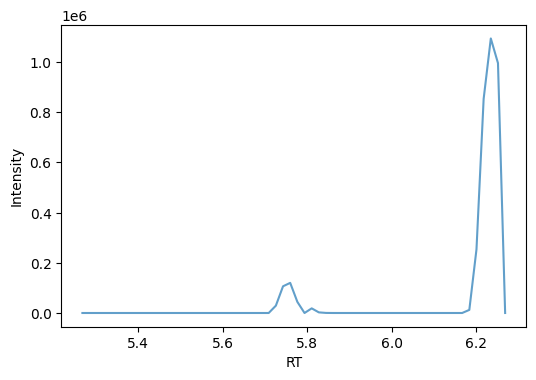

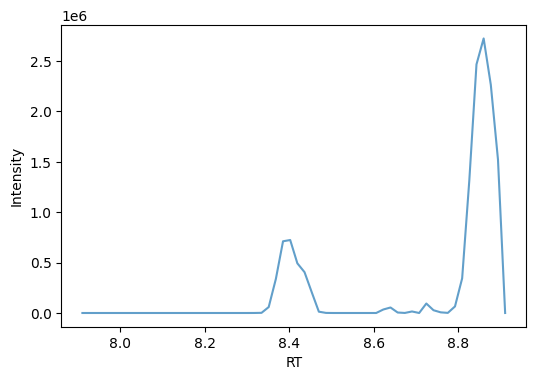

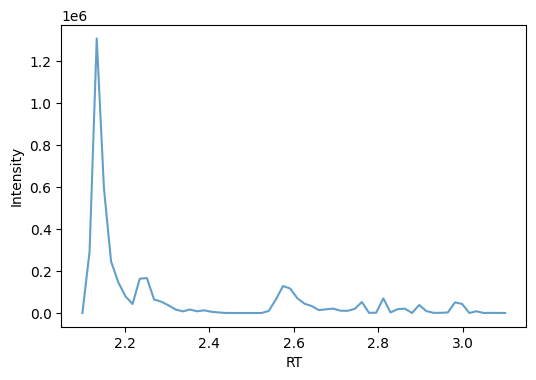

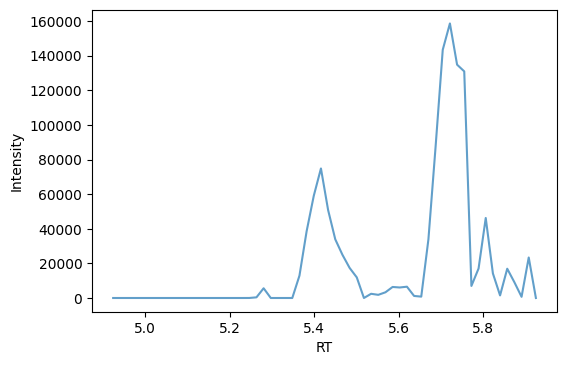

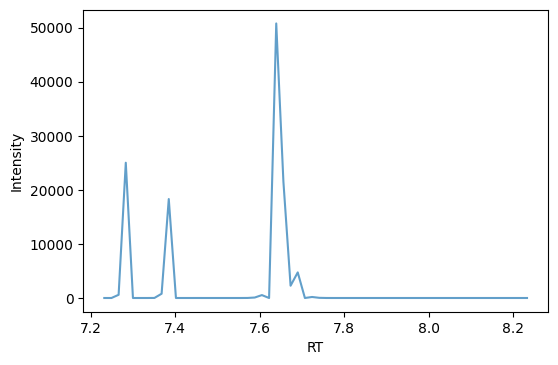

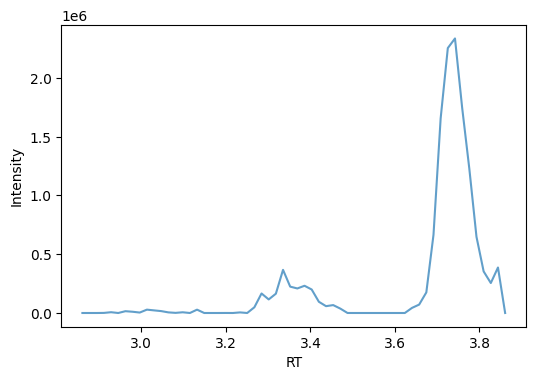

<Figure size 600x400 with 0 Axes>

In [125]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

In [126]:
xcmsCols = [x for x in peak_intensities.columns.values if ".mzML" in x and "D:" not in x]
xcms_peak_areas = peak_intensities[xcmsCols]
xcms_peak_areas

QC_01.mzML    QC_02.mzML    QC_03.mzML    QC_04.mzML    QC_05.mzML  \
FT00001  1.974936e+06  1.858493e+06  1.798871e+06  1.757297e+06  1.773365e+06   
FT00002  2.826669e+07  2.815197e+07  2.841696e+07  2.881003e+07  3.145220e+07   
FT00003  8.213799e+06  9.725321e+06  9.307397e+06  7.713435e+06  8.139520e+06   
FT00004  3.205281e+05  3.206047e+05  2.857381e+05  3.124773e+05  3.306725e+05   
FT00005  2.072345e+05  1.836083e+05  2.224421e+05  1.704847e+05  2.148285e+05   
...               ...           ...           ...           ...           ...   
FT32177  1.895676e+04  0.000000e+00  1.190416e+05  1.293768e+04  7.919847e+04   
FT32178  7.459506e+04  1.379095e+05  1.272461e+05  1.030717e+05  1.344736e+05   
FT32179  1.857563e+05  1.975252e+05  2.361436e+05  2.210434e+05  2.238891e+05   
FT32180  1.741973e+05  1.996532e+05  1.700717e+05  1.492381e+05  2.215041e+05   
FT32181  1.102636e+05  4.369822e+04  1.171374e+05  1.096281e+05  7.411829e+04   

           QC_06.mzML    QC_07.mzML  
FT00001  1.768485e+06  2.304243e+06  
FT00002  3.074870e+07  3.318160e+07  
FT00003  7.220048e+06  8.205855e+06  
FT00004  3.484202e+05  3.416744e+05  
FT00005  1.860289e+05  2.334494e+05  
...               ...           ...  
FT32177  0.000000e+00  2.039624e+05  
FT32178  1.053646e+05  7.916662e+04  
FT32179  2.395129e+05  2.108537e+05  
FT32180  1.772771e+05  2.104139e+05  
FT32181  1.437213e+05  1.249721e+05  

[32181 rows x 7 columns]

In [127]:
pdCols = [x for x in peak_intensities.columns.values if ".mzML" in x and "D:" in x]
pd_peak_areas = peak_intensities[pdCols]
pd_peak_areas

D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_01.mzML  \
FT00001                                       1.770561e+06          
FT00002                                       2.568283e+07          
FT00003                                       4.762837e+06          
FT00004                                       3.276755e+05          
FT00005                                       1.296042e+05          
...                                                    ...          
FT32177                                       0.000000e+00          
FT32178                                       5.973065e+04          
FT32179                                       2.176156e+05          
FT32180                                       1.812835e+05          
FT32181                                       1.004974e+05          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_02.mzML  \
FT00001                                       2.008296e+06          
FT00002                                       2.394791e+07          
FT00003                                       4.941783e+06          
FT00004                                       2.622989e+05          
FT00005                                       1.401095e+05          
...                                                    ...          
FT32177                                       5.157589e+04          
FT32178                                       1.556282e+05          
FT32179                                       2.059655e+05          
FT32180                                       1.917104e+05          
FT32181                                       8.135251e+04          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_03.mzML  \
FT00001                                       1.659026e+06          
FT00002                                       2.556129e+07          
FT00003                                       4.356988e+06          
FT00004                                       2.428972e+05          
FT00005                                       1.802996e+05          
...                                                    ...          
FT32177                                       0.000000e+00          
FT32178                                       1.380368e+05          
FT32179                                       2.192636e+05          
FT32180                                       1.818603e+05          
FT32181                                       1.158303e+05          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_04.mzML  \
FT00001                                       1.705139e+06          
FT00002                                       2.652860e+07          
FT00003                                       3.887249e+06          
FT00004                                       3.643616e+05          
FT00005                                       1.282977e+05          
...                                                    ...          
FT32177                                       0.000000e+00          
FT32178                                       0.000000e+00          
FT32179                                       2.151174e+05          
FT32180                                       1.425529e+05          
FT32181                                       1.060767e+05          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_05.mzML  \
FT00001                                       1.653035e+06          
FT00002                                       2.814166e+07          
FT00003                                       4.938783e+06          
FT00004                                       2.980086e+05          
FT00005                                       1.462846e+05          
...                                                    ...          
FT32177                                       4.890063e+04          
FT32178                                       1.571294e+05          
FT32179                                       2.106176e+05          
FT3

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


0.5155145037651298

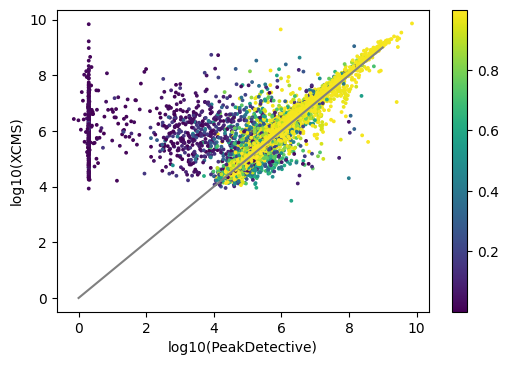

In [128]:
plt.scatter(np.log10(pd_peak_areas.values.mean(axis=1)+2),np.log10(xcms_peak_areas.values.mean(axis=1)),s=3,c=peak_scores[pdCols].values.mean(axis=1))
plt.plot([0,9],[0,9],color="grey")
plt.xlabel("log10(PeakDetective)")
plt.ylabel("log10(XCMS)")
plt.colorbar()
met.r2_score(pd_peak_areas.values.mean(axis=1),xcms_peak_areas.values.mean(axis=1))